# Nuclear chromatin phenotypes of PBMCs distinguish control and cancer populations

---
This notebook summarizes the analysis corresponding to the results presented in figure 2 of the paper. It can be used to rerun the analysis and regenerate the corresponding panels.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300

import sys

sys.path.append("../..")
from src.utils.notebooks.eda import *
from src.utils.notebooks.figure3 import *
from src.utils.notebooks.figure2 import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

seed = 1234
random.seed(1234)
np.random.seed(1234)

%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import re


def sorted_nicely(l):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

<IPython.core.display.Javascript object>

In [3]:
color_palette = {"Control": "mediumseagreen", "Cancer": "tomato"}

<IPython.core.display.Javascript object>

---

## 1. Read in data

To assess the differences in the cancer populations compared to the control population, we obtained PBMCs of 10 healthy control samples and 10 cancer patients of various cancer types. For each patient we obtained a number of images of the PBMCs showing their DNA, gH2AX and Lamin A/C content using corresponding fluorescent stains.

First, we read in the required data set that describe each PBMCs by a number of hand-crafted features extracted from the fluorescent images of the cells.

In [4]:
hv_root_data_dir = "../../data/control/proteins/"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"

<IPython.core.display.Javascript object>

In [5]:
hv_data = read_in_protein_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)
hv_data["id"] = hv_data["sample"] + hv_data["timepoint"]
hv_data["condition"] = "Control"
hv_data["file_name"] = np.array(list(hv_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 35.76it/s]


<IPython.core.display.Javascript object>

In [6]:
pancancer_root_data_dir = "../../data/pancancer/proteins/timepoint_1"

pancancer_data = read_in_protein_dataset(
    data_dir=pancancer_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
)
pancancer_data["id"] = pancancer_data["sample"] + pancancer_data["timepoint"]
pancancer_data["condition"] = "Cancer"
pancancer_data["file_name"] = np.array(list(pancancer_data.index))

Load data: 100%|██████████| 10/10 [00:00<00:00, 24.50it/s]


<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

Before we analyze the data, we will first preprocess it.

To this end, we first remove features with missing values and samples with missing features.

In [7]:
hv_data = preprocess_data(hv_data, remove_constant_features=False)
pancancer_data = preprocess_data(pancancer_data, remove_constant_features=False)

all_data = hv_data.append(pancancer_data)

Nuclei that did not pass the quality check: 185/2531. Remaining: 2346.
Removed 12 constant or features with missing values. Remaining: 271.
Removed additional 6 features. Remaining: 265.
Nuclei that did not pass the quality check: 240/5276. Remaining: 5036.
Removed 12 constant or features with missing values. Remaining: 271.
Removed additional 6 features. Remaining: 265.


<IPython.core.display.Javascript object>

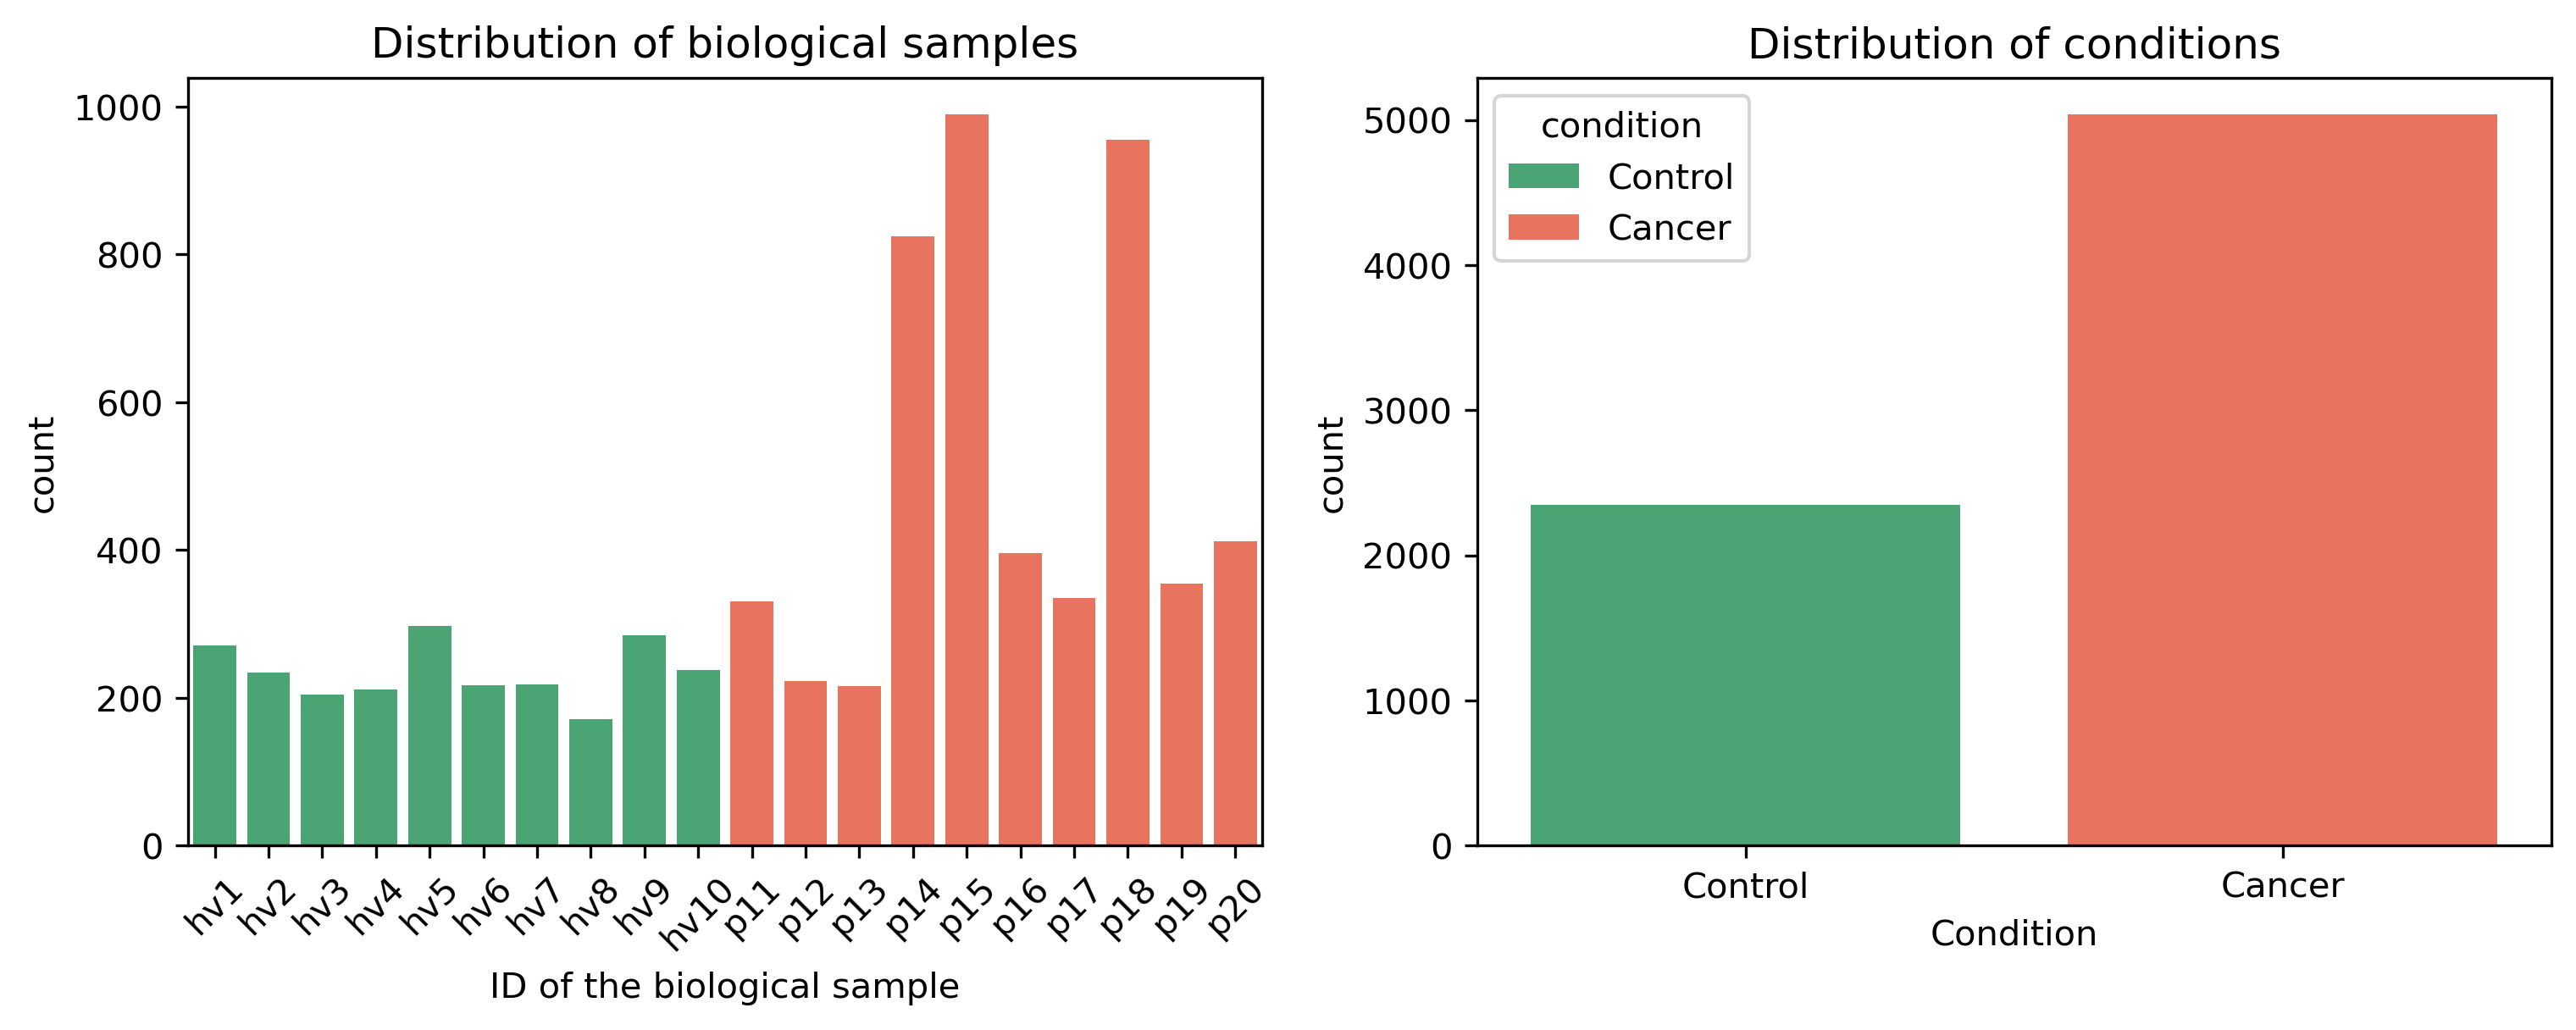

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
cond_order = ["Control", "Cancer"]
sample_order = sorted_nicely(np.unique(all_data.loc[:, "sample"]))
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=all_data,
    ax=ax[0],
    order=sample_order,
    hue_order=cond_order,
    hue="condition",
    dodge=False,
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="condition",
    hue="condition",
    data=all_data,
    ax=ax[1],
    order=cond_order,
    dodge=False,
    palette=color_palette,
    hue_order=cond_order,
)
ax[1].set_xlabel("Condition")
ax[1].set_title("Distribution of conditions")

plt.show()
plt.close()

Note that while the data set consists of 10 cancer patients and 10 healthy controls the number of nuclei varies significantly between each biological sample.

___

#### Subsampling

We first subsample the data set such that for each condition (control vs. cancer) we have the same number of nuclei in the data set. Additionally, we ensure that for the cancer population we have approximately equal number of nuclei from each biological sample.

In [9]:
sampled_data = get_stratified_data(hv_data, pancancer_data)

<IPython.core.display.Javascript object>

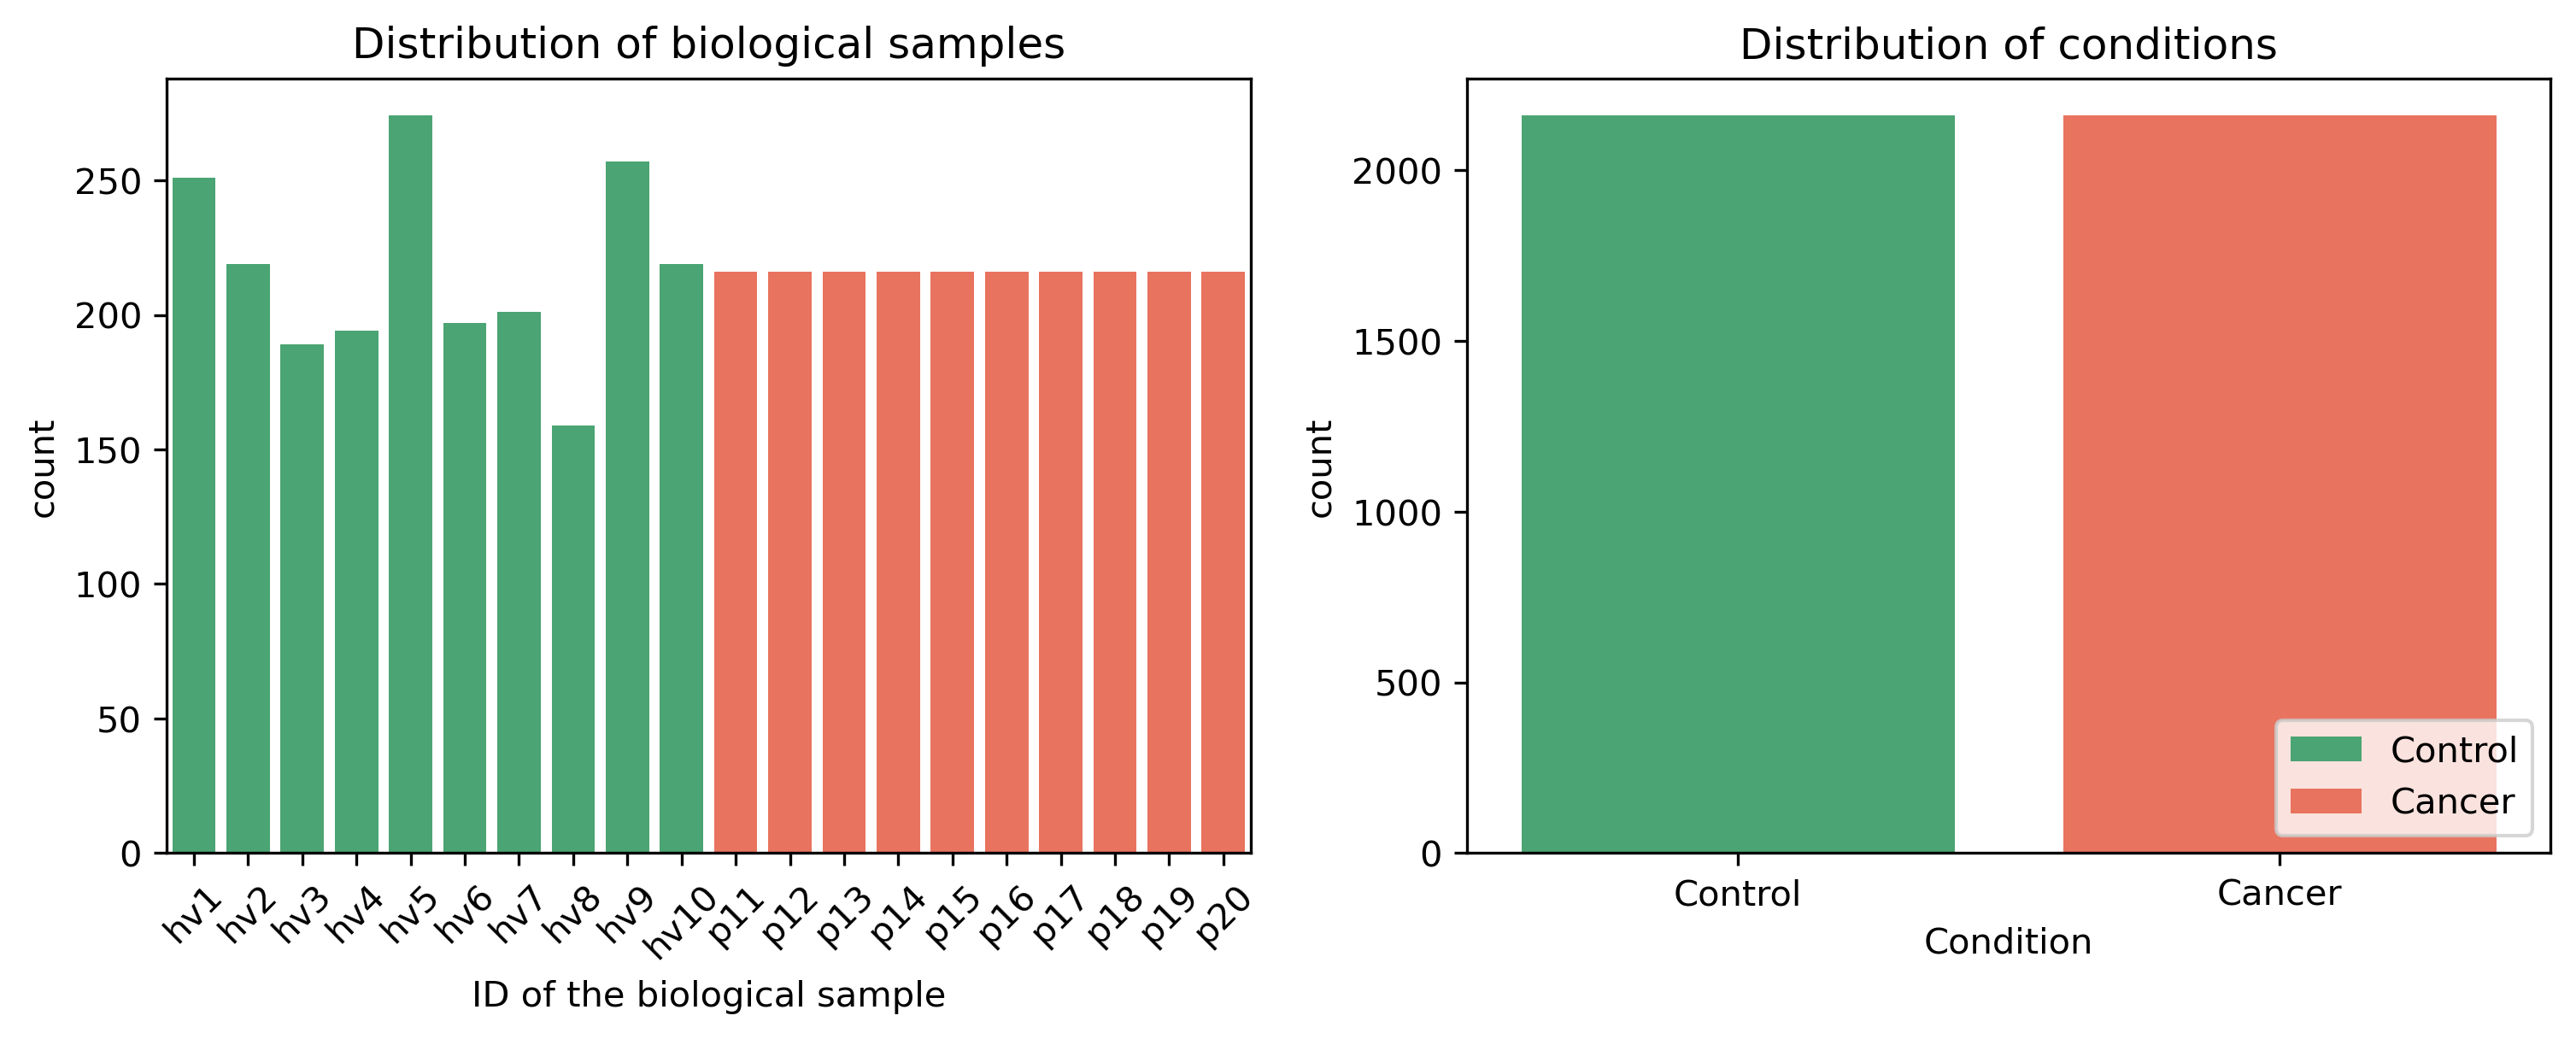

<IPython.core.display.Javascript object>

In [10]:
fig, ax = plt.subplots(figsize=[12, 4], ncols=2)
cond_order = ["Control", "Cancer"]
sample_order = sorted_nicely(np.unique(all_data.loc[:, "sample"]))
ax = ax.flatten()
ax[0] = sns.countplot(
    x="sample",
    data=sampled_data,
    ax=ax[0],
    order=sample_order,
    hue_order=cond_order,
    hue="condition",
    dodge=False,
    palette=color_palette,
)
ax[0].legend([], [], frameon=False)
ax[0].set_xlabel("ID of the biological sample")
ax[0].set_title("Distribution of biological samples")
for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

ax[1] = sns.countplot(
    x="condition",
    hue="condition",
    data=sampled_data,
    ax=ax[1],
    order=cond_order,
    dodge=False,
    palette=color_palette,
    hue_order=cond_order,
)
ax[1].set_xlabel("Condition")
ax[1].set_title("Distribution of conditions")
ax[1].legend(loc="lower right")

plt.show()
plt.close()

The sampled data set consists of 2160 nuclei from the healthy controls as well as from the cancer patients.

----

#### Sample and feature selection

We now filter out constant features and nuclei with missing features. We will do that for both replicates individually. However, we will also combine the two replicates to provide a joint analysis.

In [11]:
data = preprocess_data(sampled_data, remove_constant_features=True)

Nuclei that did not pass the quality check: 0/4320. Remaining: 4320.
Removed 4 constant or features with missing values. Remaining: 261.
Removed additional 0 features. Remaining: 261.


<IPython.core.display.Javascript object>

---

#### Data preparation

After sampling the data, we will now prepare the data for the consecutive analysis, i.e. extracting only chrometric features and corresponding metadata information.

In [12]:
all_chrometric_data = get_chrometric_data(
    data,
    proteins=["gh2ax", "lamin"],
    exclude_dna_int=True,
)

sample_labels = data.loc[:, "sample"]
cond_labels = data.loc[:, "condition"]

<IPython.core.display.Javascript object>

Finally, we remove highly correlated features (Pearson $\rho > 0.8$) from the chrometric features.

In [13]:
chrometric_data = remove_correlated_features(all_chrometric_data, threshold=0.8)

Removed 146/193 features with a Pearson correlation above 0.8. Remaining: 47


<IPython.core.display.Javascript object>

---

## 3. Panels

Now we generate the individual panels for figure 2 of the paper.


### 3a. Visualization of the global nuclear phenotypes of control vs cancer population

First, we provide a visual representation of the different nuclear phenotypes in health and cancer. To this end, we will randomly sample 36 nuclei from each condition and plot a corresponding montage of the max-z projected DNA images. To visualize size differences each nuclei is padded to a size of 150x150 pixels.

In [14]:
image_file_path = "preprocessed/full_pipeline/segmentation/nuclei_images"
sampled_ctrl_images = get_random_images(
    data.loc[data.condition == "Control"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
)

sampled_cancer_images = get_random_images(
    data.loc[data.condition == "Cancer"],
    image_file_path,
    data_dir_col="data_dir",
    n_images=36,
    seed=1234,
    file_ending=".tif",
)

<IPython.core.display.Javascript object>

#### Control population

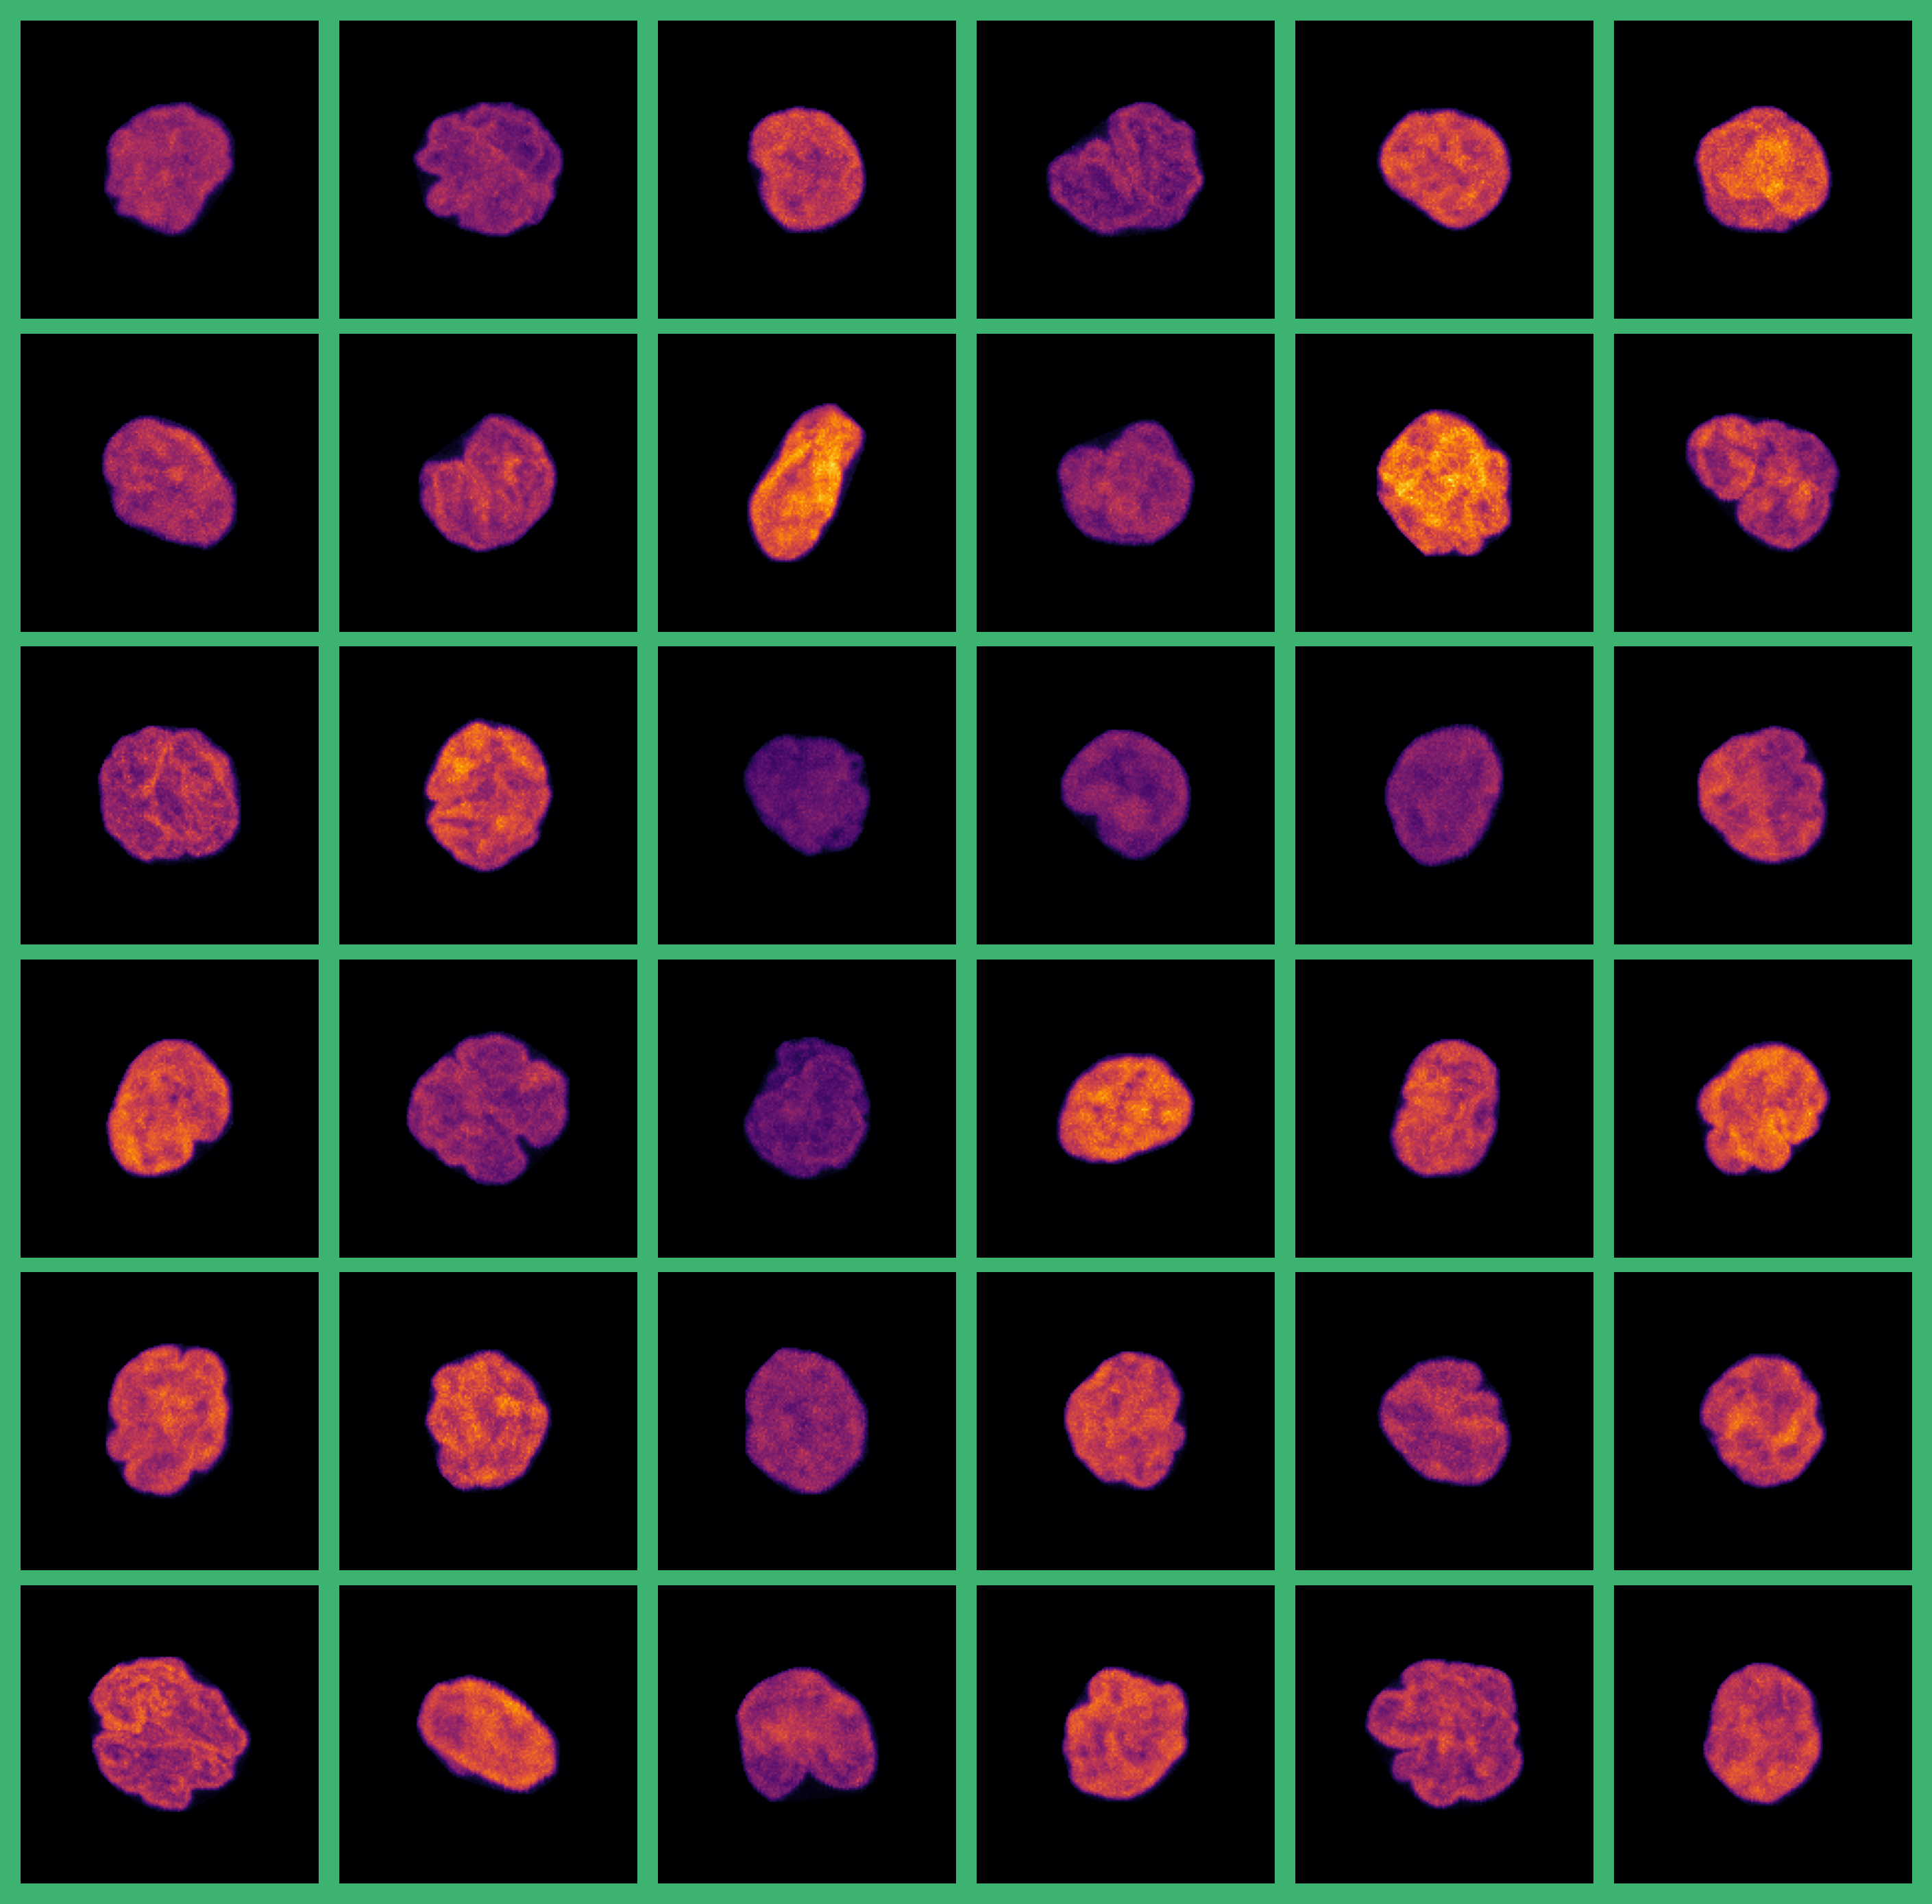

<IPython.core.display.Javascript object>

In [15]:
fig_ctrl, ax_ctrl = plot_montage(
    sampled_ctrl_images, pad_size=150, cmap="inferno", channel_first=False
)
fig_ctrl.set_facecolor(color_palette["Control"])

#### Cancer population

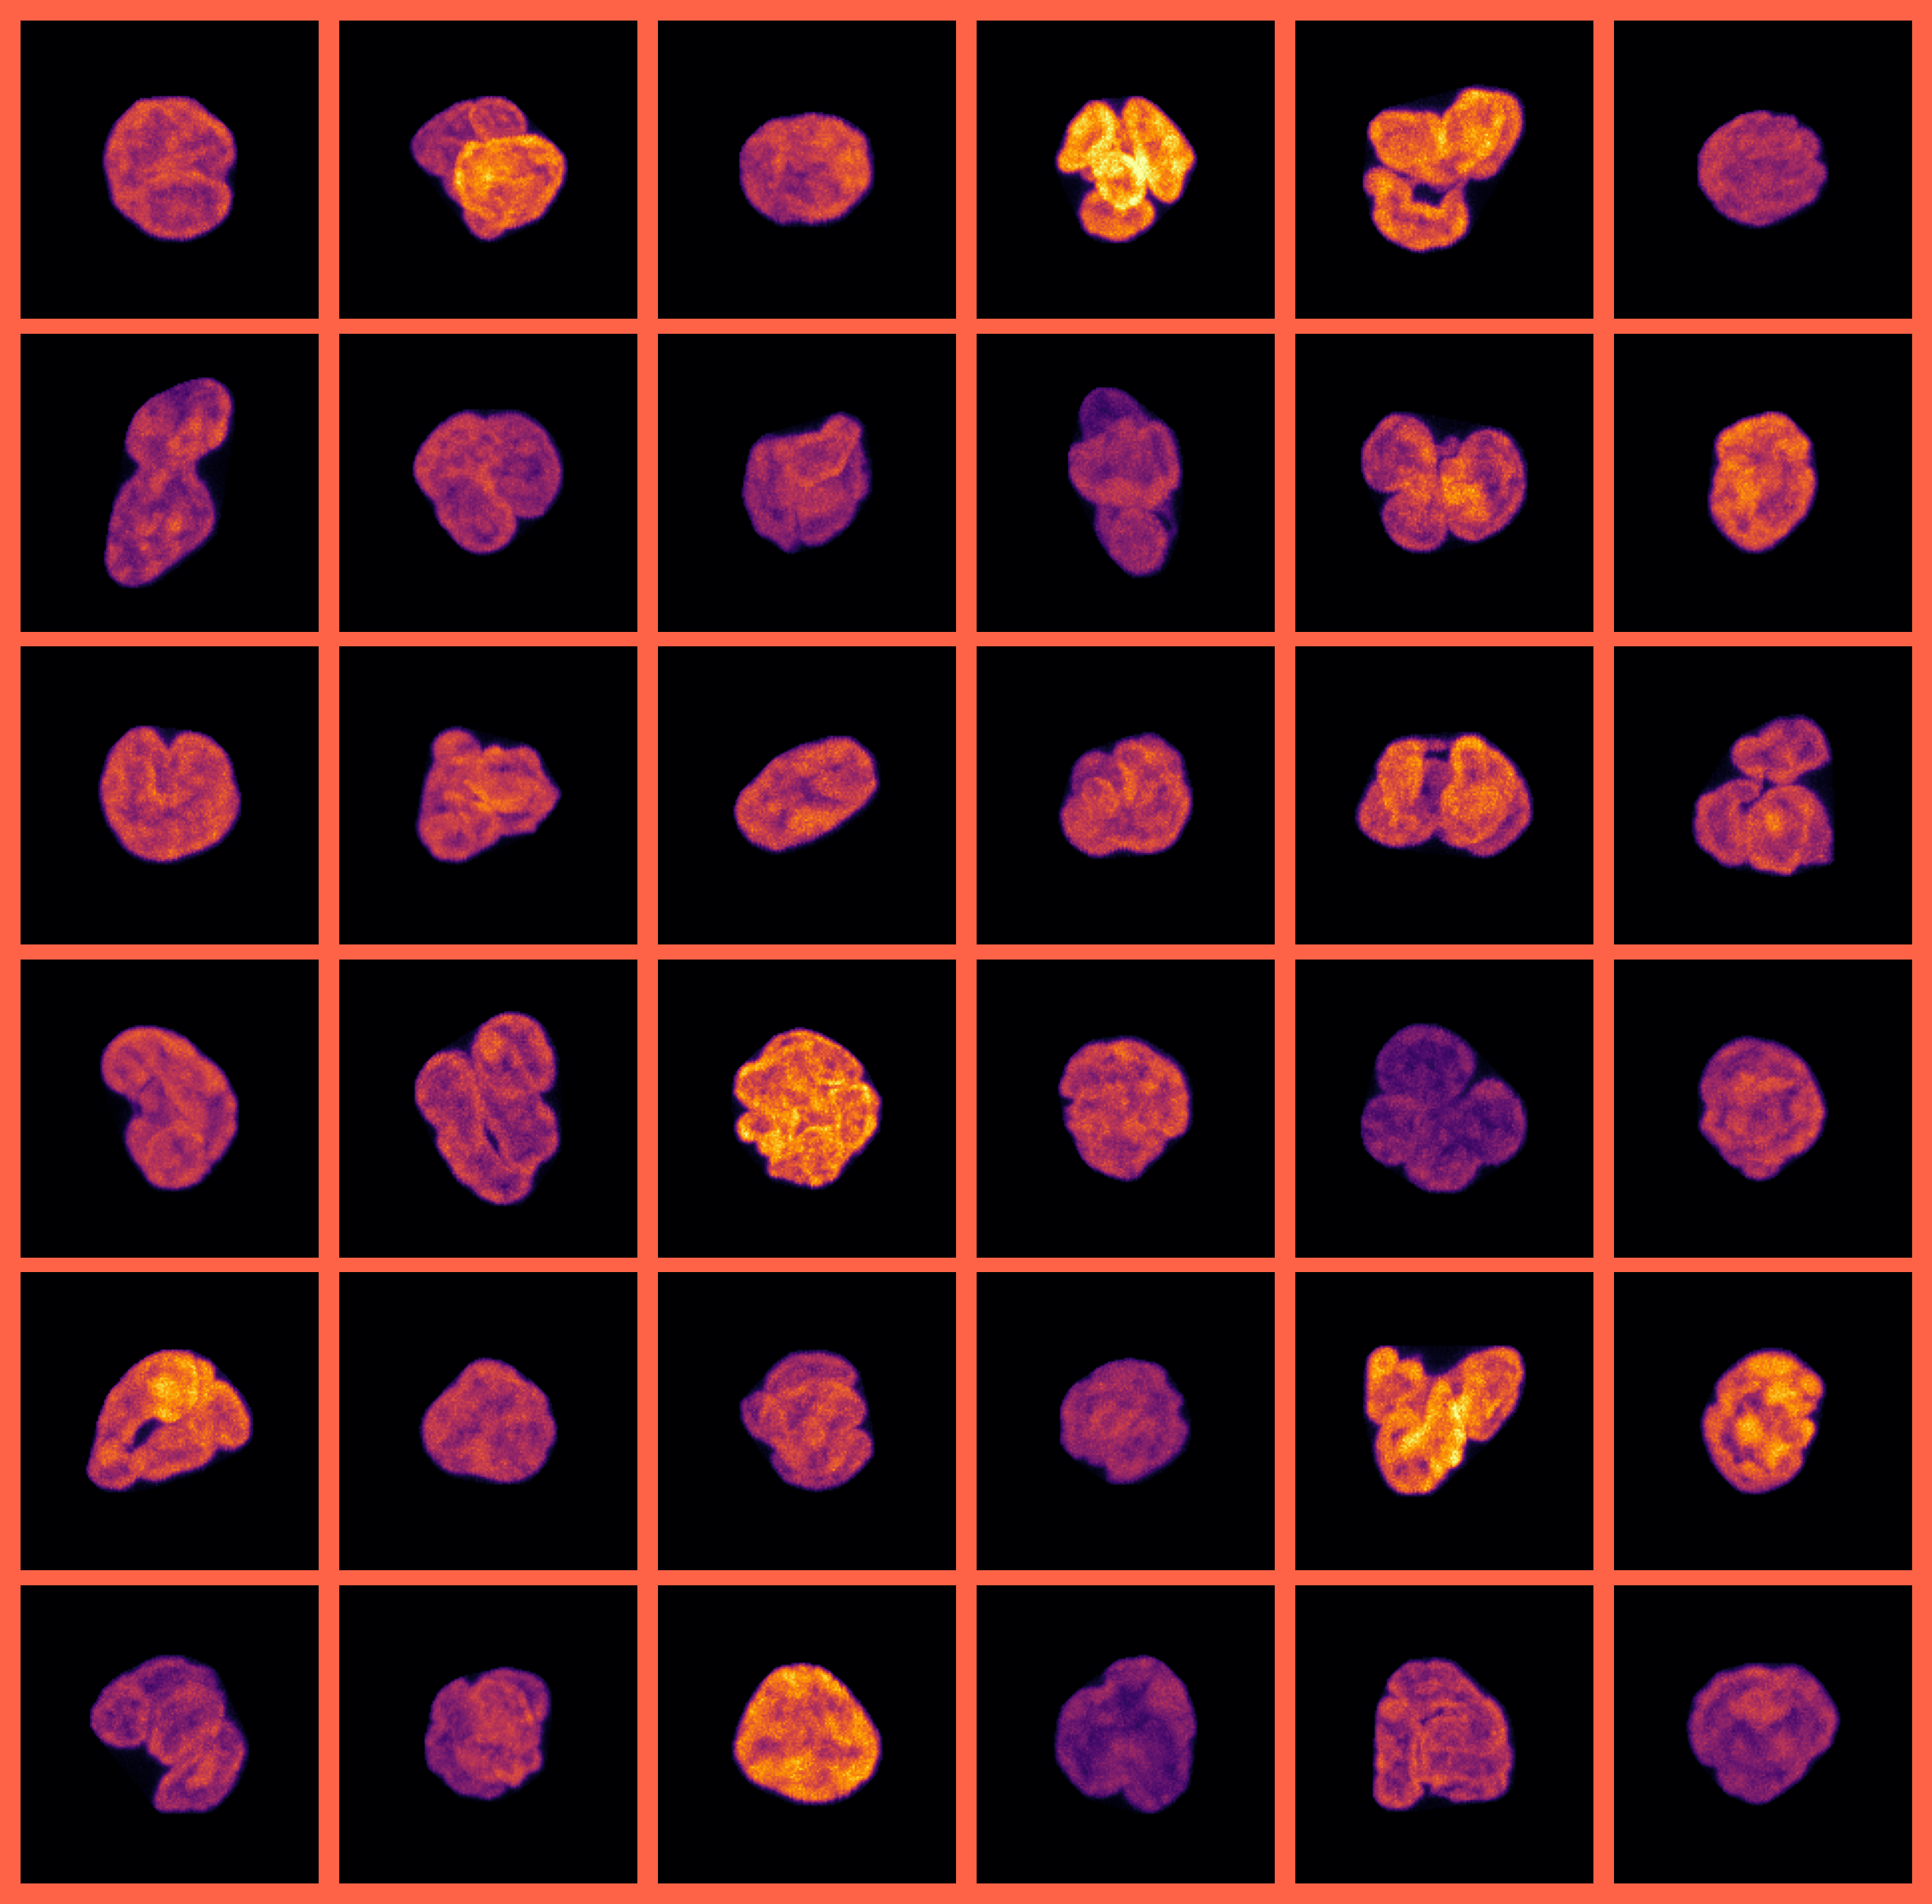

<IPython.core.display.Javascript object>

In [16]:
fig_cancer, ax_cancer = plot_montage(
    sampled_cancer_images, pad_size=150, cmap="inferno", channel_first=False
)
fig_cancer.set_facecolor(color_palette["Cancer"])

The above montages show that the nuclei of the cancer samples often feature a signficantly different chrometric phenotype compared to those of PBMCs from the healthy controls. For instance we observe a frequent fragmentation of the nucleus which leads to highly concave nuclear shape.

---

### 3b. Parametric analysis captures large-scale differences between control and cancer population

We will now use the chrometric features to describe the nuclear phenotype of the PBMCs in the two conditions and assess their differences. To this end, we first visualize the data set using a tSNE plot to visualize the high-dimensional data set in 2D and show the large-scale differences of the chrometric phenotypes of PBMCs in healthy and cancer subjects respectively.

In [17]:
chrometric_embs = get_tsne_embs(chrometric_data)
chrometric_embs["condition"] = np.array(cond_labels)
chrometric_embs["sample"] = np.array(sample_labels)

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

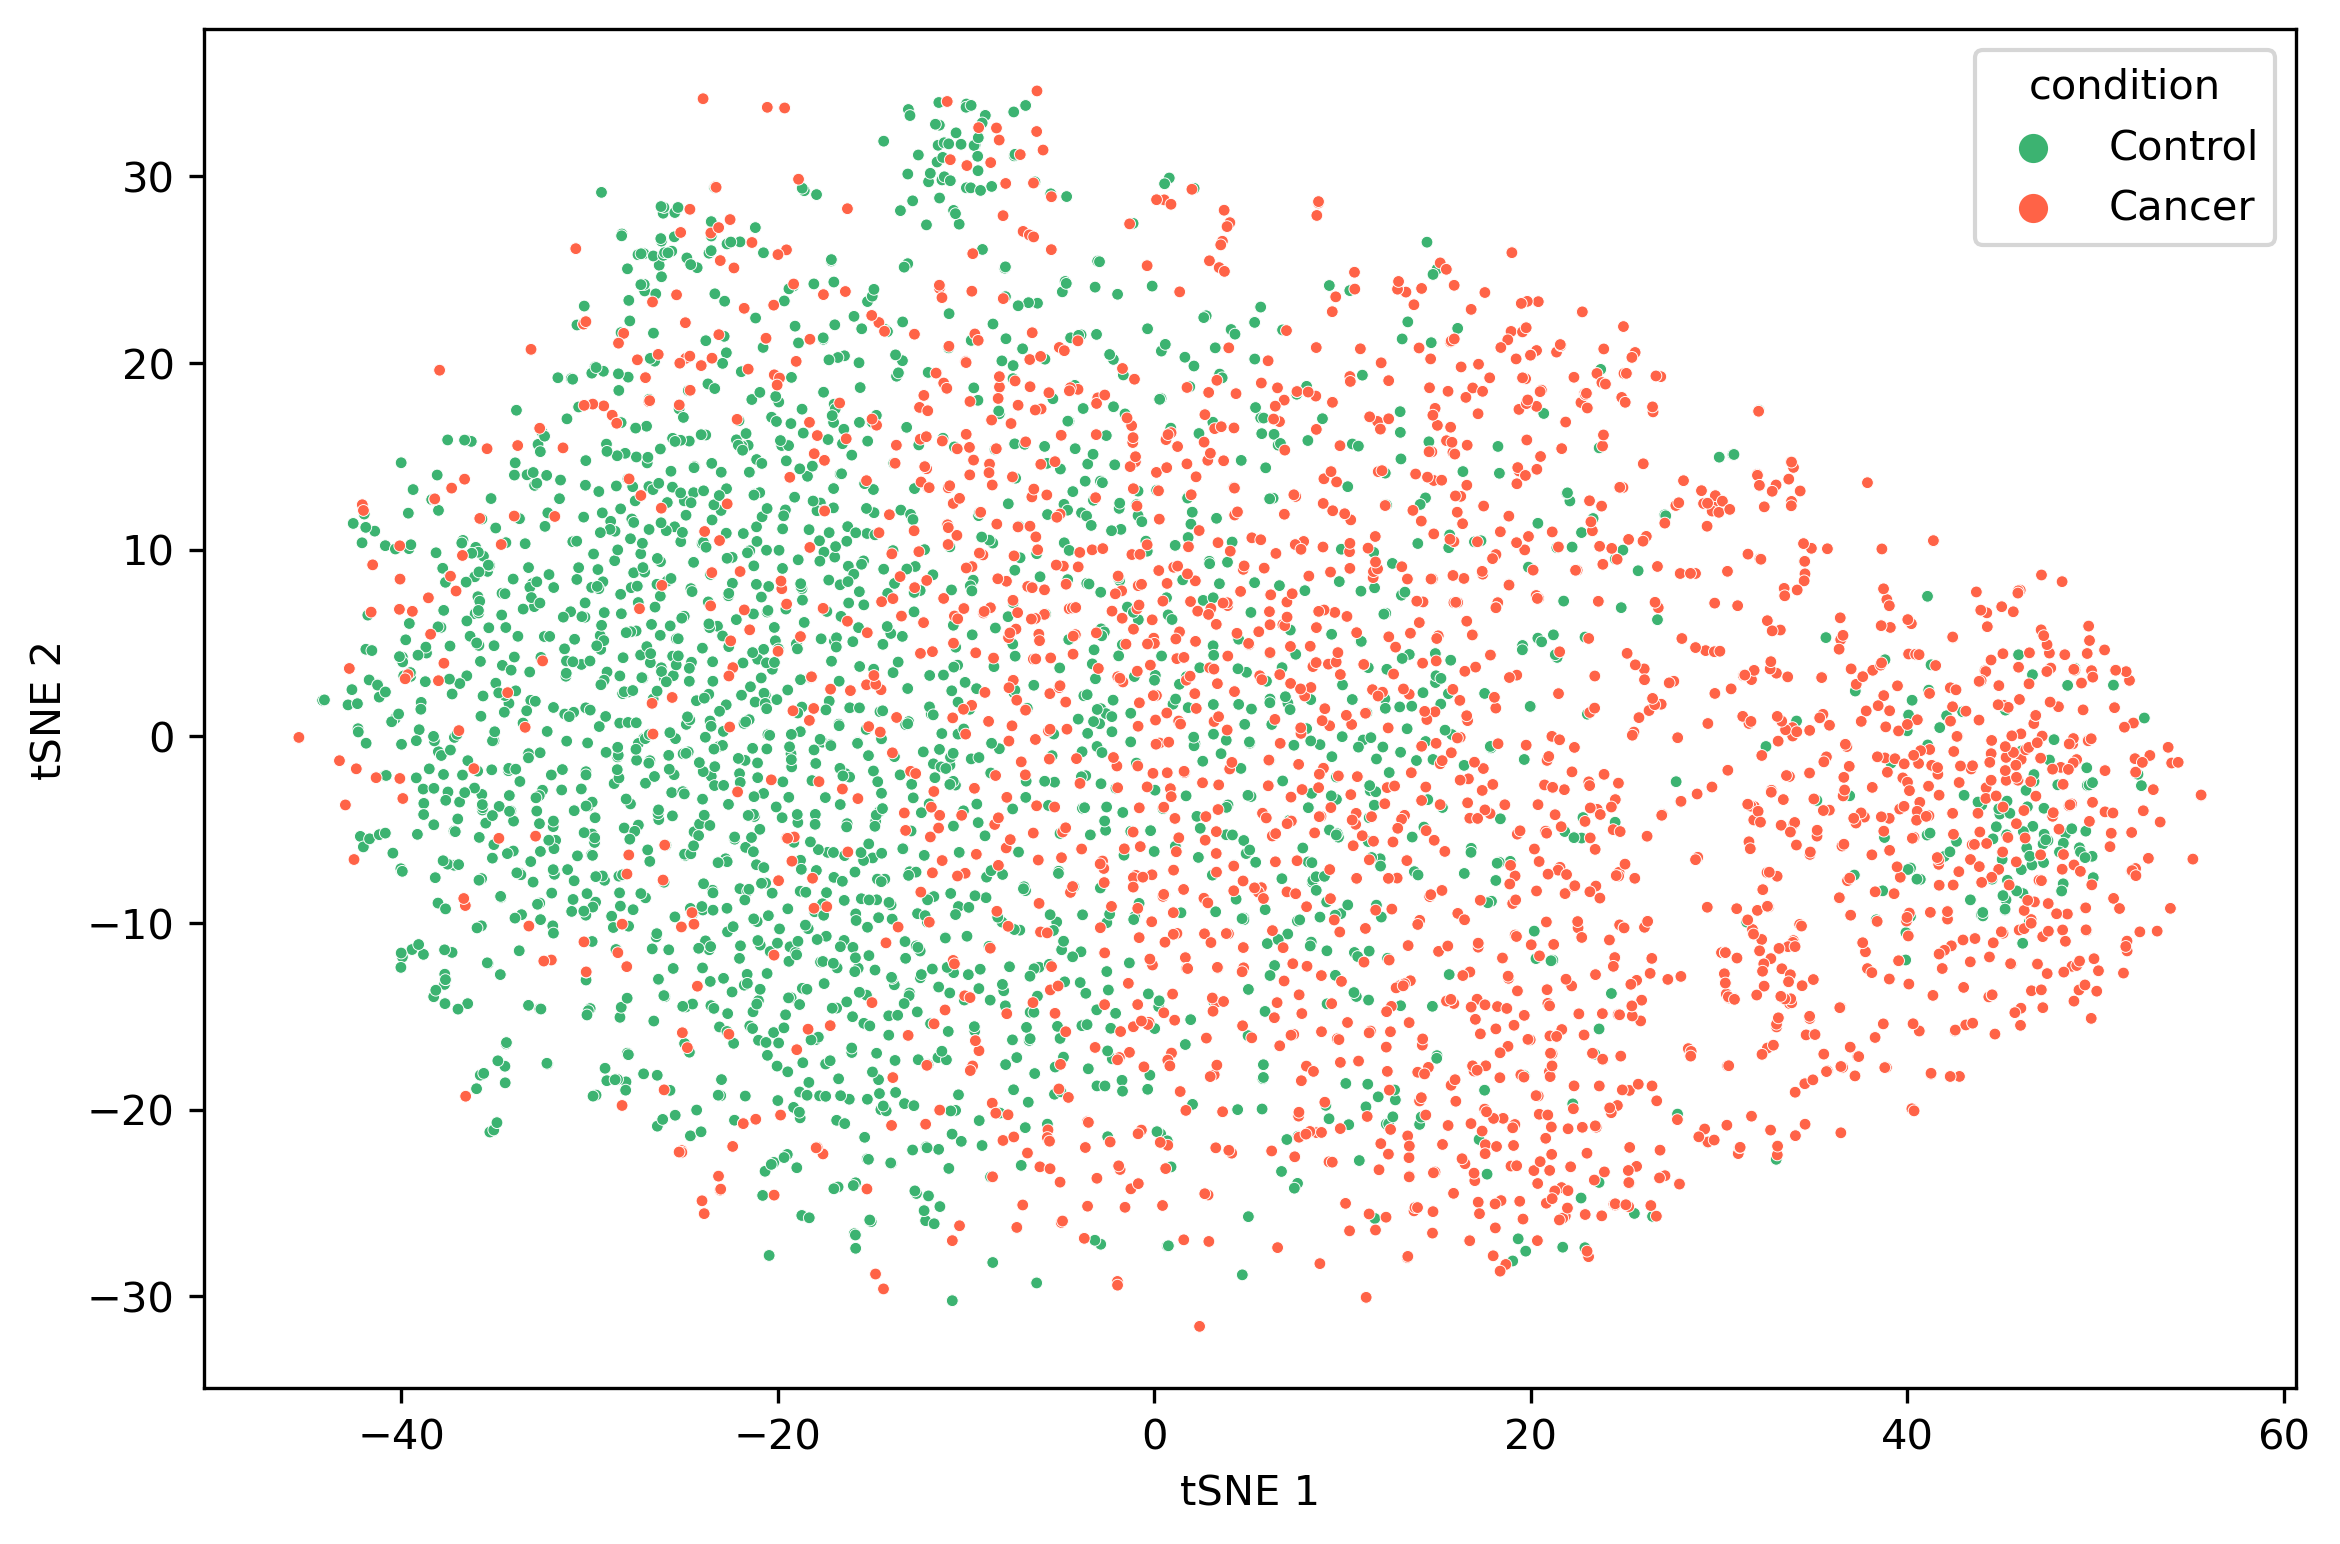

<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="condition",
    hue_order=cond_order,
    ax=ax,
    s=8,
    marker="o",
    palette=color_palette,
)
plt.show()

In [19]:
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.scatterplot(
    data=chrometric_embs,
    x="tSNE 1",
    y="tSNE 2",
    hue="sample",
    hue_order=sample_order,
    ax=ax,
    s=8,
    marker="o",
    palette="tab20",
)
plt.legend(
    bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0, title="sample"
)
plt.show()

<IPython.core.display.Javascript object>

---

#### Classification of the control resp. cancer PBMCs

To quantify the separability of the two conditions we perform a 10-fold stratified cross-validation analysis using a RandomForest classifier. The classifier provides a simple non-linear classification model which also yields an importance measure for the individual chrometric features indicating which ones are most different between the two populations.

In [20]:
rfc = RandomForestClassifier(
    n_estimators=500, n_jobs=10, random_state=seed, class_weight="balanced"
)

<IPython.core.display.Javascript object>

##### Nuclei split

At first we will split the data randomly on a nuclei-basis, i.e. nuclei of the same biological sample will be likely included in both the training and the test sets.

In [21]:
cond_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=cond_labels,
    scale_features=False,
    n_folds=10,
    order=cond_order,
)
normalized_cv_conf_mtx_nuclei = cond_cv_conf_mtx_nuclei.divide(
    cond_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted condition")
ax.set_ylabel("True condition")
plt.show()

<IPython.core.display.Javascript object>

The classifier is able to accurately distinguish nuclei from the control and cancer population. This suggests that there are large differences with respect to the chrometric phenotypes of PBMCs in the absence compared to in the presence of cancer. While the tSNE plot already suggested that this is the case, a linear discriminant analysis shows that using a linear combination of the chrometric features the two classes can be accurately distinguished.

In [23]:
lda = LinearDiscriminantAnalysis(n_components=1)

<IPython.core.display.Javascript object>

In [24]:
lda_cond_cv_conf_mtx_nuclei = get_cv_conf_mtx(
    estimator=lda,
    features=chrometric_data,
    labels=cond_labels,
    scale_features=True,
    n_folds=10,
    order=cond_order,
)
lda_normalized_cv_conf_mtx_nuclei = lda_cond_cv_conf_mtx_nuclei.divide(
    lda_cond_cv_conf_mtx_nuclei.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

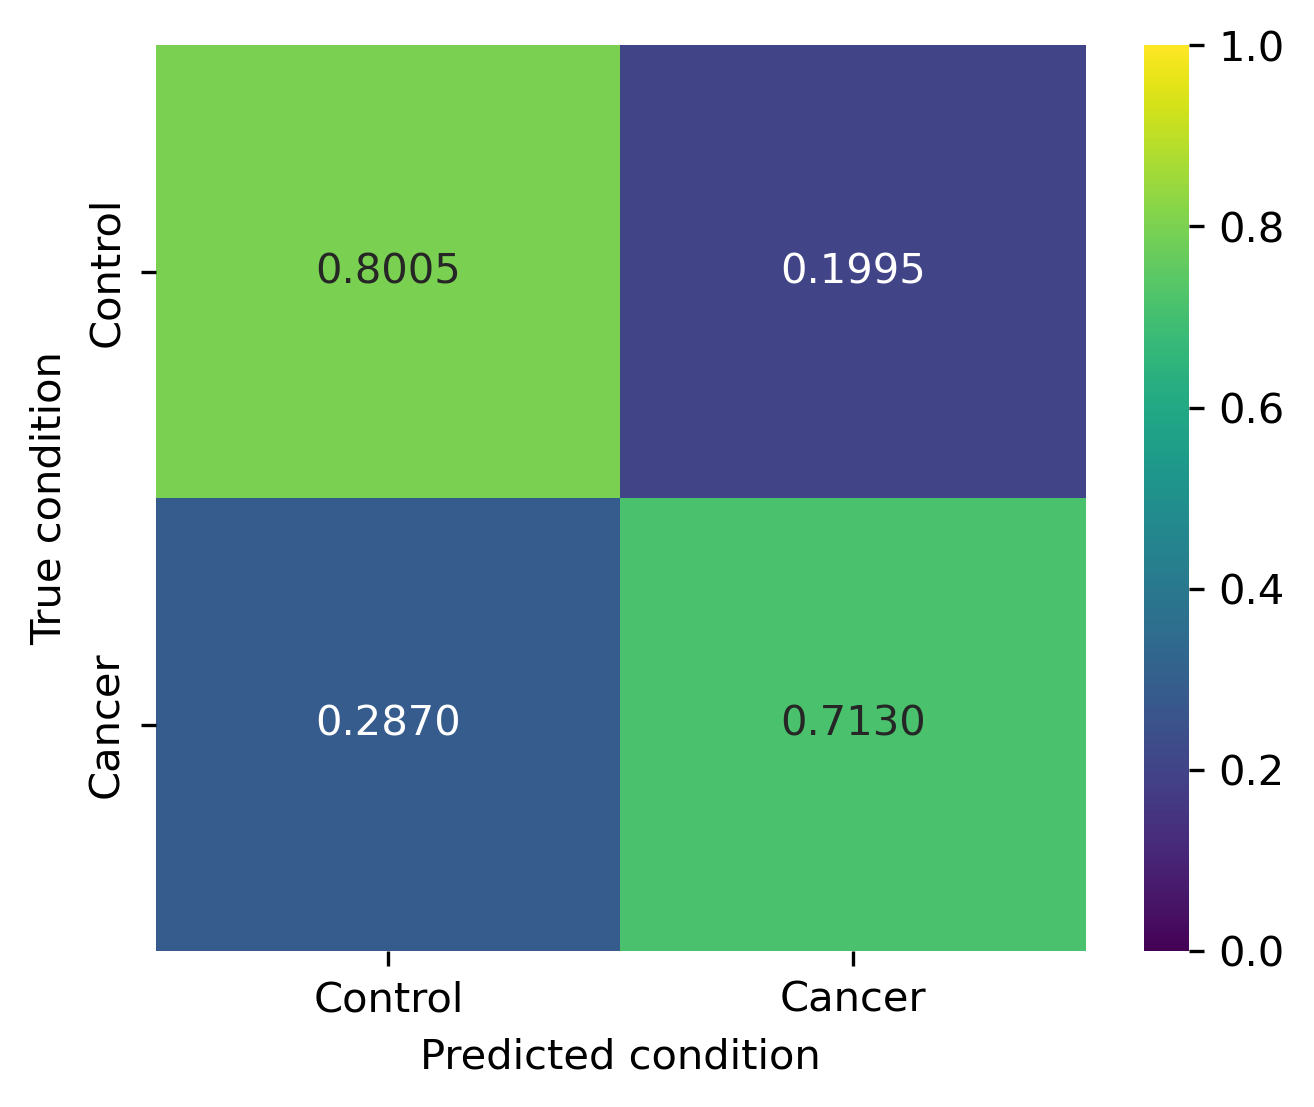

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    lda_normalized_cv_conf_mtx_nuclei,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted condition")
ax.set_ylabel("True condition")
plt.show()

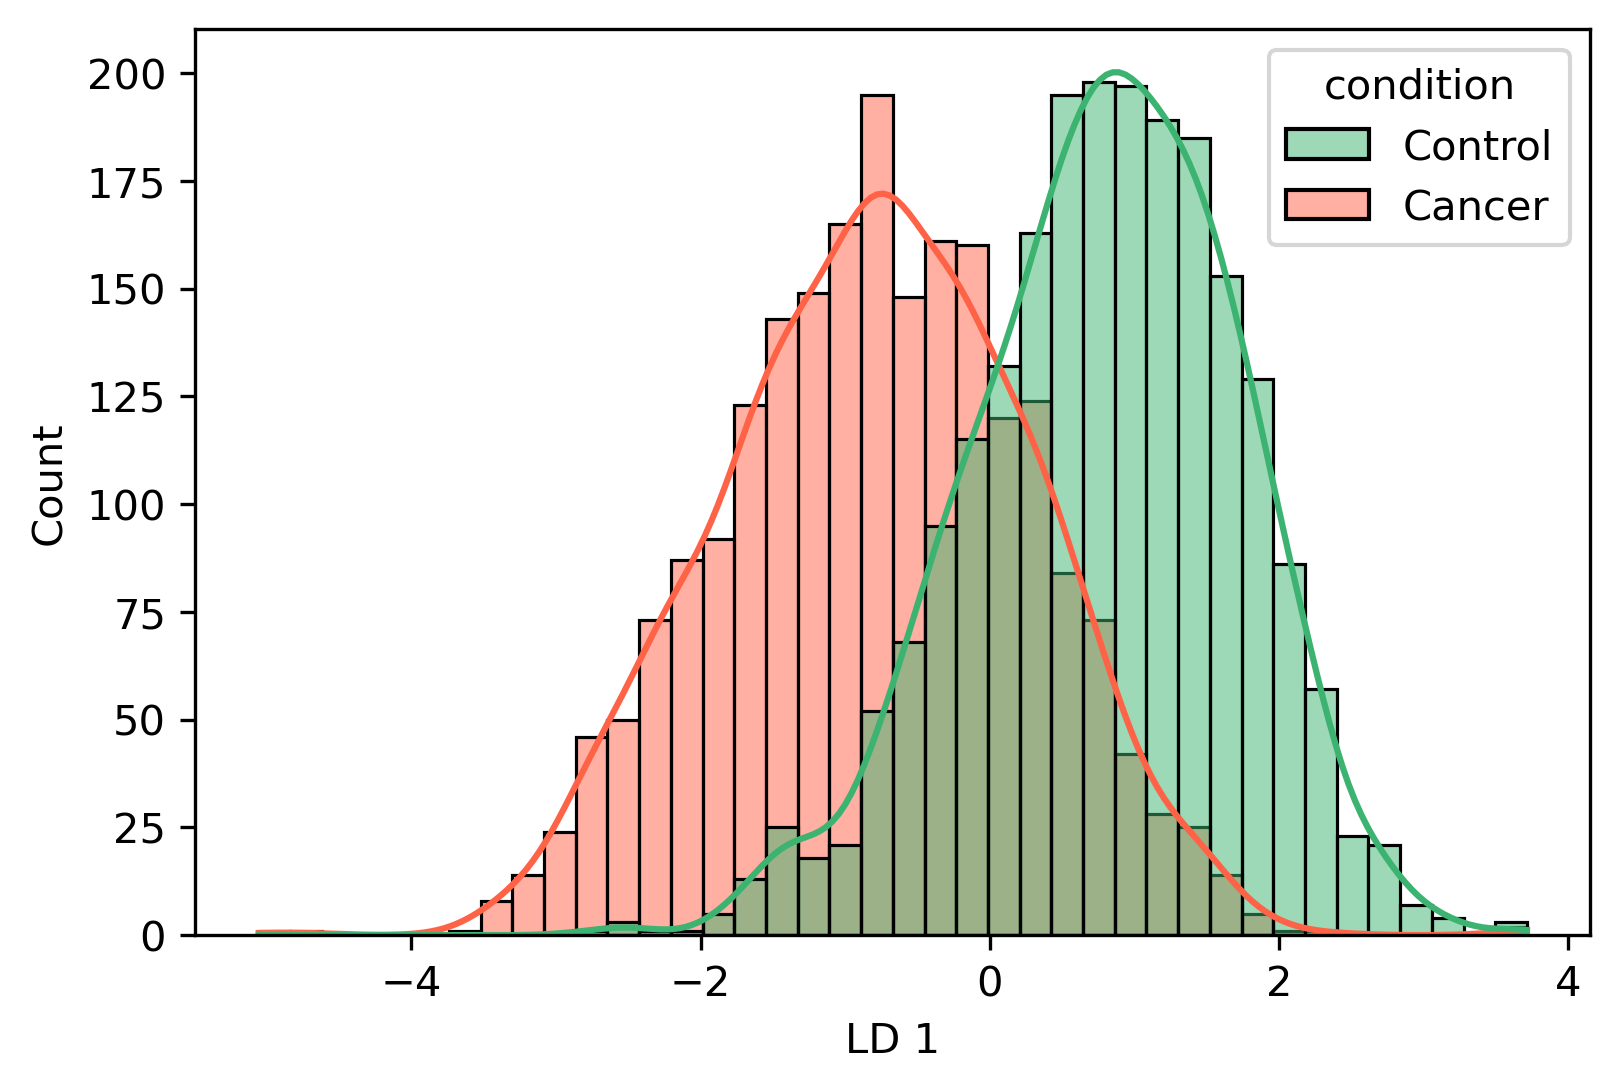

<IPython.core.display.Javascript object>

In [26]:
lda_transformed = pd.DataFrame(
    lda.fit(chrometric_data, cond_labels).transform(chrometric_data),
    columns=["LD 1"],
    index=chrometric_data.index,
)
lda_transformed["condition"] = np.array(cond_labels)
lda_transformed["sample"] = np.array(sample_labels)
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.histplot(
    data=lda_transformed,
    x="LD 1",
    hue="condition",
    hue_order=cond_order,
    palette=color_palette,
    kde=True,
)

---
#### Patient split


While the previous analysis assess the level of differences of the chrometric phenotypes of the PBMCs between the control and cancer population, the classifier can make use of patient specific characteristics during the classification. In a diagnostic use case such information would not be available. To evaluate how well a classifier would be able to predict for unseen patient the corresponding condition simply based on the chrometric phenotypes of the PBMCs, we also assess the class separability using a stratified 5-fold patient-cross-validation approach. Thereby at each iteration 2 of the patients of each condition (healthy control and cancer) are hold out for the test set.

In [27]:
cond_cv_conf_mtx_patient = get_cv_conf_mtx(
    estimator=rfc,
    features=chrometric_data,
    labels=cond_labels,
    groups=sample_labels,
    scale_features=False,
    n_folds=5,
    order=cond_order,
)
normalized_cv_conf_mtx_patient = cond_cv_conf_mtx_patient.divide(
    cond_cv_conf_mtx_patient.sum(axis=1), axis=0
)

<IPython.core.display.Javascript object>

In [28]:
fig, ax = plt.subplots(figsize=[5, 4])
ax = sns.heatmap(
    normalized_cv_conf_mtx_patient,
    annot=True,
    fmt=".4f",
    cmap="viridis",
    vmin=0,
    vmax=1,
    # cbar=False,
)
ax.set_xlabel("Predicted condition")
ax.set_ylabel("True condition")
plt.show()

<IPython.core.display.Javascript object>

---

### 3c. Nuclear chromatin biomarkers identifying cancer populations


#### Feature importance

After having validated that there are significant differences between the control and the cancer population with respect to the chrometric pheontypes of the PBMCS, we next assess the implicit feature importance of a RandomForest classifier trained on the task to distinguish between control and cancer samples in order to get an idea of the features which are most indicative of the cancer condition.

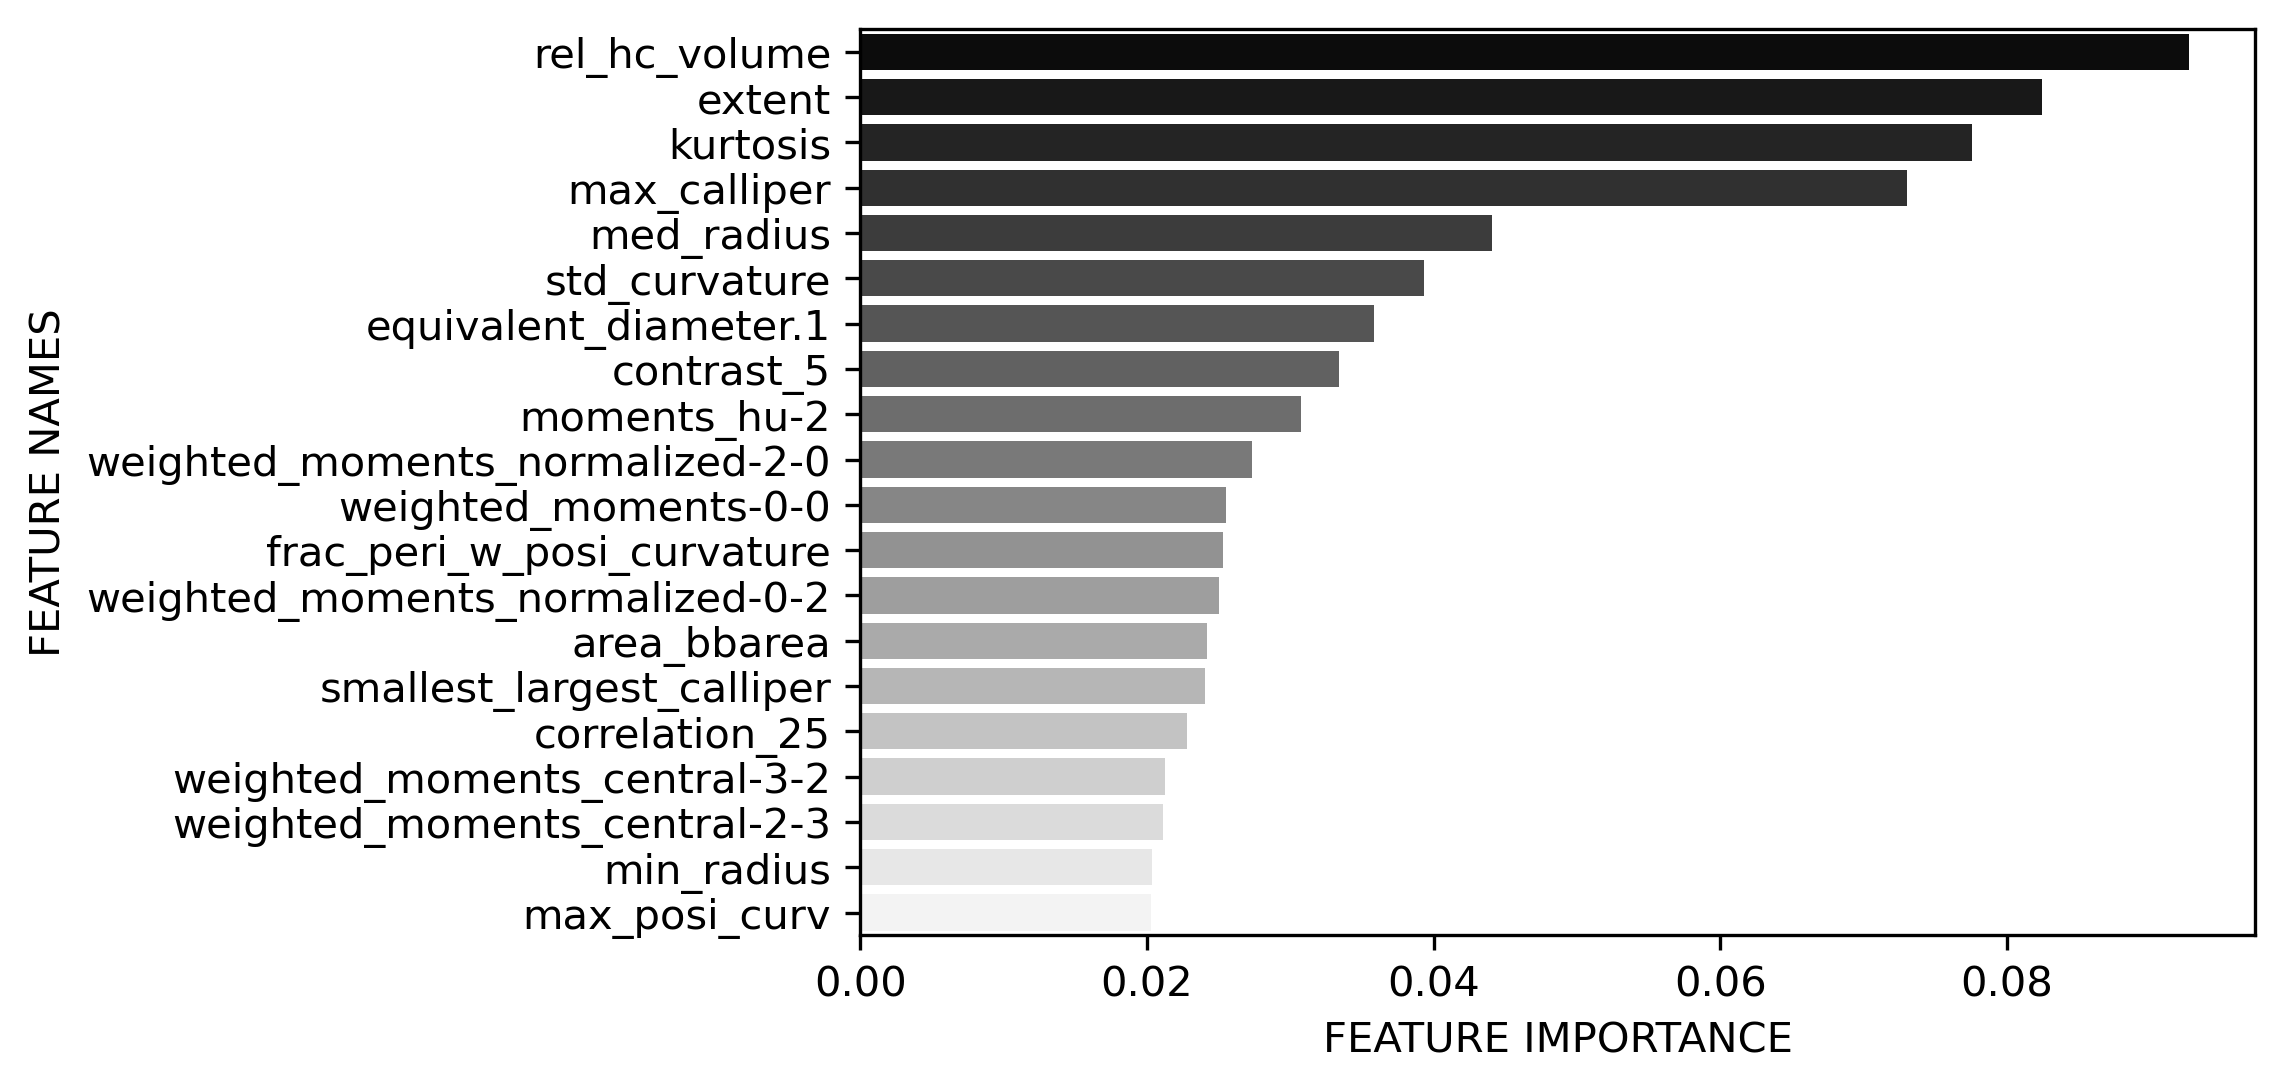

<IPython.core.display.Javascript object>

In [29]:
fig, ax = plot_feature_importance_for_estimator(
    rfc,
    chrometric_data,
    cond_labels,
    scale_features=False,
    cmap="gray",
    figsize=[6, 4],
)

The analysis suggests that the heterochromatin content, the size of the nucleus, its shape as well as the DNA intensity distribution of the DNA inside the nucleus are altered in the cancer population.

---

### 3c. Nuclear chromatin biomarkers identifying cancer populations

While the previously shown feature importance plots already suggest a number of candidate chrometric biomarkers that capture the differences of the nuclear phenotypes of the PBMCs in the different cancer types, we run marker screen by testing for differential distributions of the individual chrometric features between the control and cancer population. To this end, we apply a t-test to test for difference in the means and adjust for multiple testing using the Benjamini-Hochberg procedure.

In [30]:
marker_screen_results = find_markers(chrometric_data, cond_labels)

Run marker screen:   0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [31]:
marker_screen_results.loc[marker_screen_results.label == "Cancer"].head(10)

label                           marker        fc  abs_delta_fc  \
1   Cancer                     max_calliper  1.111297      0.111297   
13  Cancer                         kurtosis  0.312936      0.687064   
44  Cancer                           extent  0.890026      0.109974   
45  Cancer                    rel_hc_volume  1.075707      0.075707   
4   Cancer                       med_radius  1.059133      0.059133   
6   Cancer                    std_curvature  1.173784      0.173784   
5   Cancer                      area_bbarea  0.963362      0.036638   
28  Cancer  weighted_moments_normalized-2-2  1.400989      0.400989   
17  Cancer                  homogeneity_100  4.873986      3.873986   
2   Cancer        smallest_largest_calliper  0.937541      0.062459   

             pval    pval_adjust  
1   2.876585e-241  1.351995e-239  
13  1.878878e-240  4.415363e-239  
44  1.581189e-207  2.477196e-206  
45  1.737266e-184  2.041288e-183  
4   8.462780e-158  7.955013e-157  
6   1.141989e-123  8.945579e-123  
5    2.382484e-92   1.599668e-91  
28   1.839497e-90   1.080705e-89  
17   1.665150e-79   8.695784e-79  
2    5.965526e-79   2.803797e-78

<IPython.core.display.Javascript object>

We find that the most significantly different features are a number of size features such as the maximum caliper and median radius, as well as features related to the curvature of the nucleus and the intranuclear chromatin compaction in the (rel_hc_volume and kurtosis) as well as the nuclear shape related (extent)

---

As a joint proxy to study the alterations in size, we focus at the nuclear volume, the variation in the shape by the concavity as well as the aspect ratio of the nucleus and the change in chromatin compaction by the relative heterochromatin to euchromatin ratio.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:3.229e-74 t=-1.858e+01


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:3.008e-186 t=-3.060e+01


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:4.138e-263 t=-3.721e+01


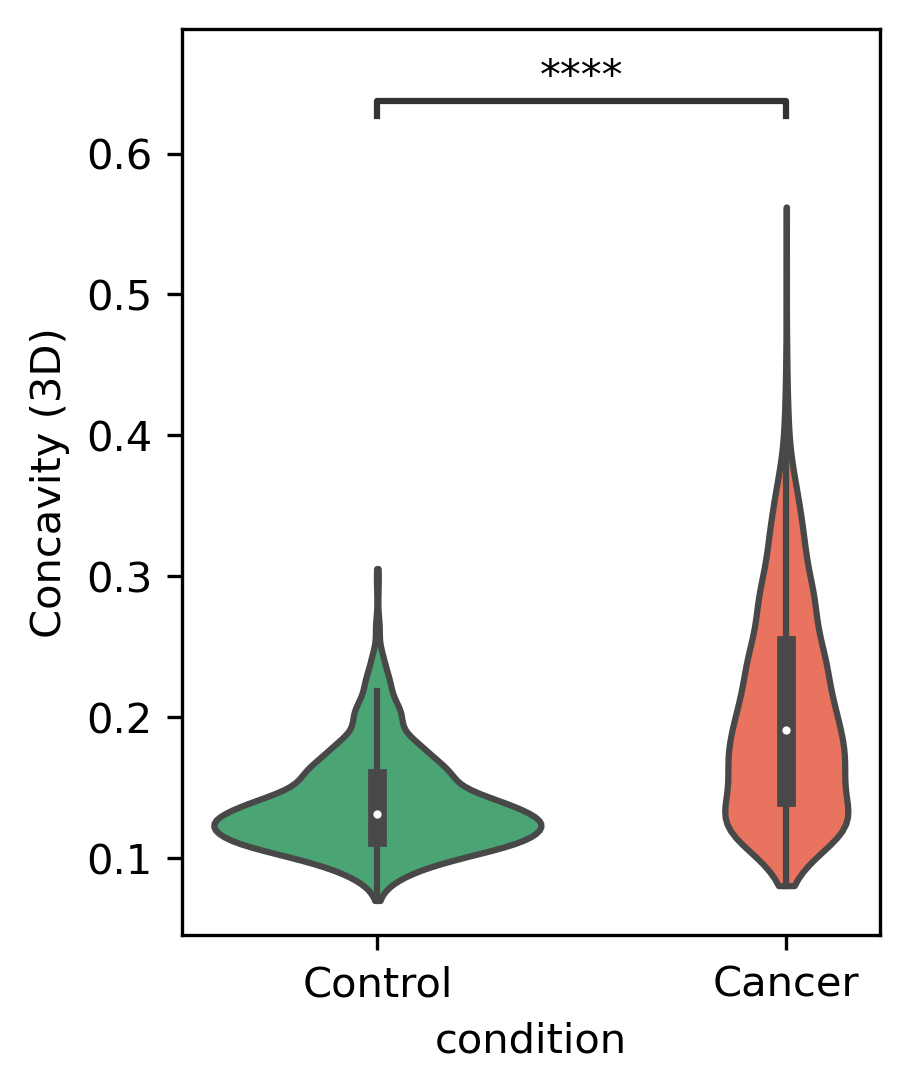

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:7.581e-65 t=1.729e+01


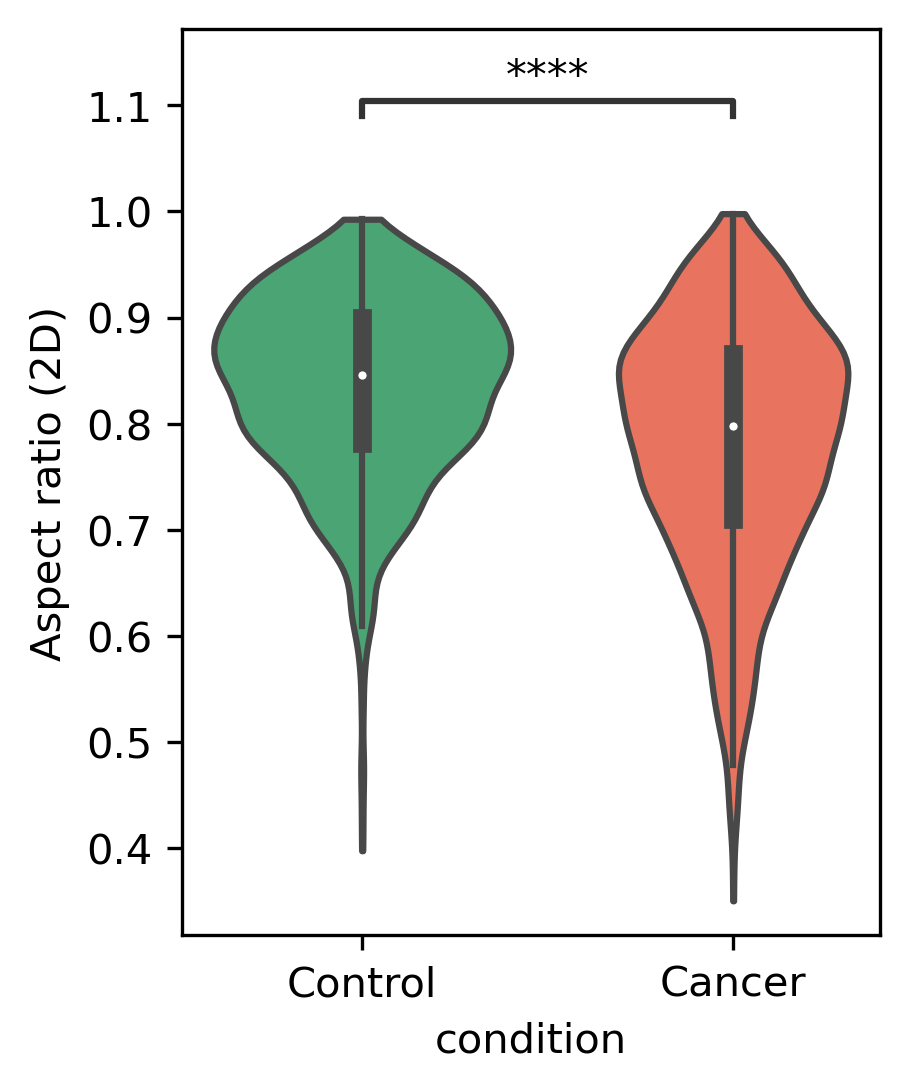

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:8.338e-124 t=-2.445e+01


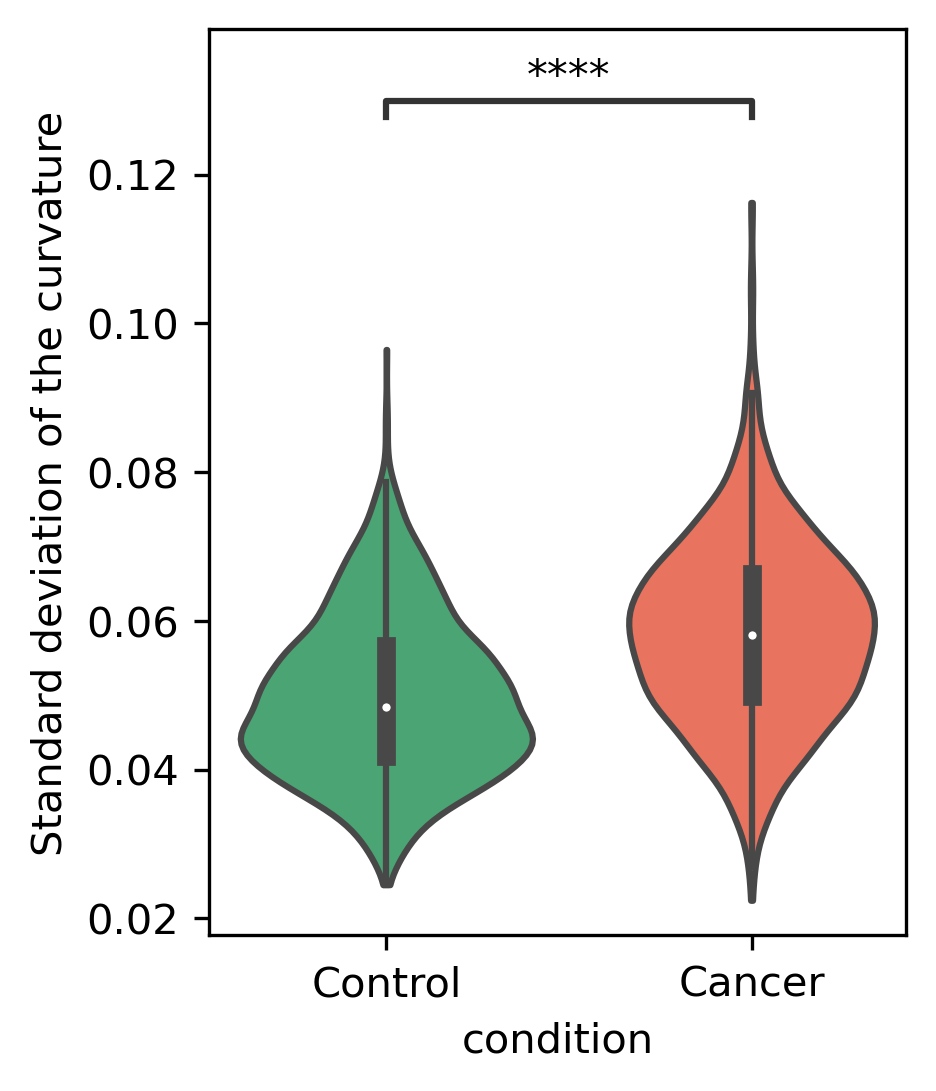

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:3.282e-243 t=3.557e+01


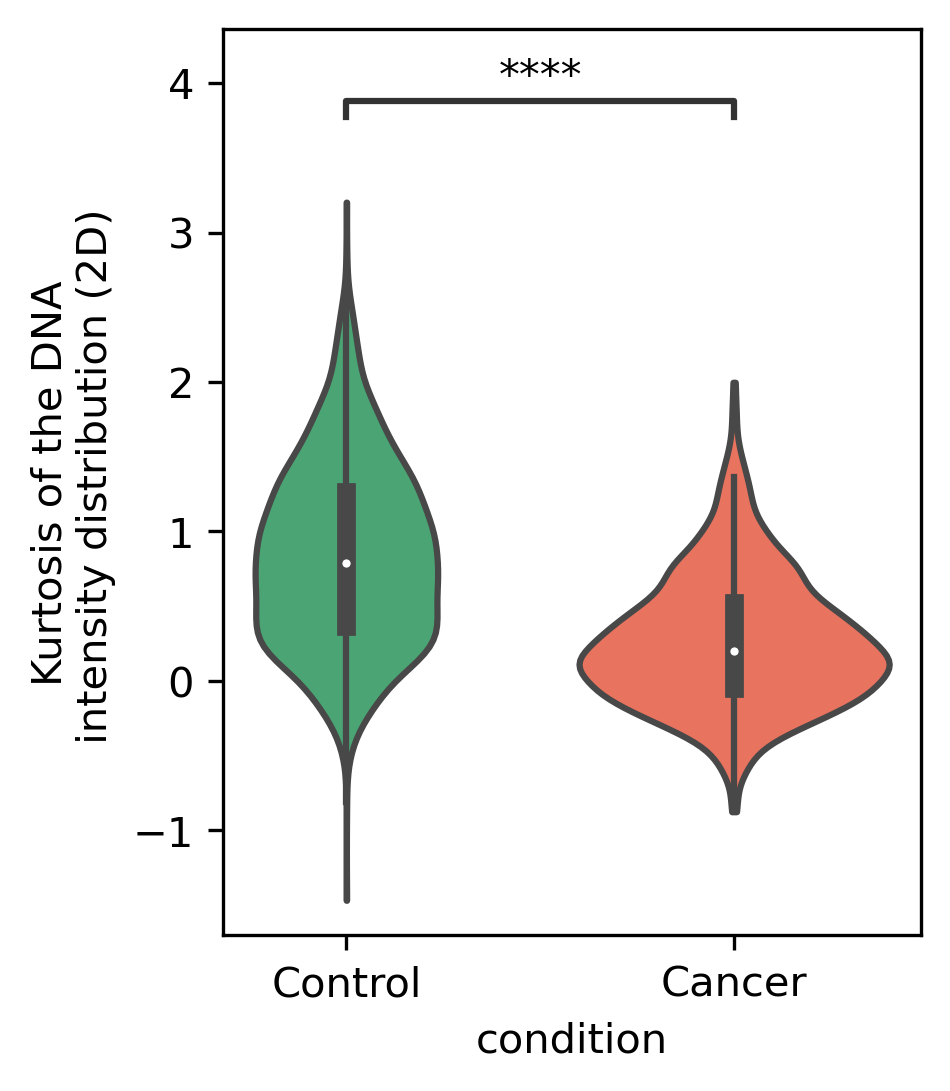

<IPython.core.display.Javascript object>

In [32]:
markers = [
    "nuclear_volume",
    "hc_ec_ratio_3d",
    "concavity_3d",
    "a_r",
    "std_curvature",
    "kurtosis",
]
marker_labels = [
    r"Nuclear volume in px$^3$",
    "Relative HC/EC ratio",
    "Concavity (3D)",
    "Aspect ratio (2D)",
    "Standard deviation of the curvature",
    "Kurtosis of the DNA\n intensity distribution (2D)",
]
plot_ctrl_cancer_markers_dist(
    data, markers, marker_labels, cut=0, palette=color_palette
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:3.229e-74 t=-1.858e+01


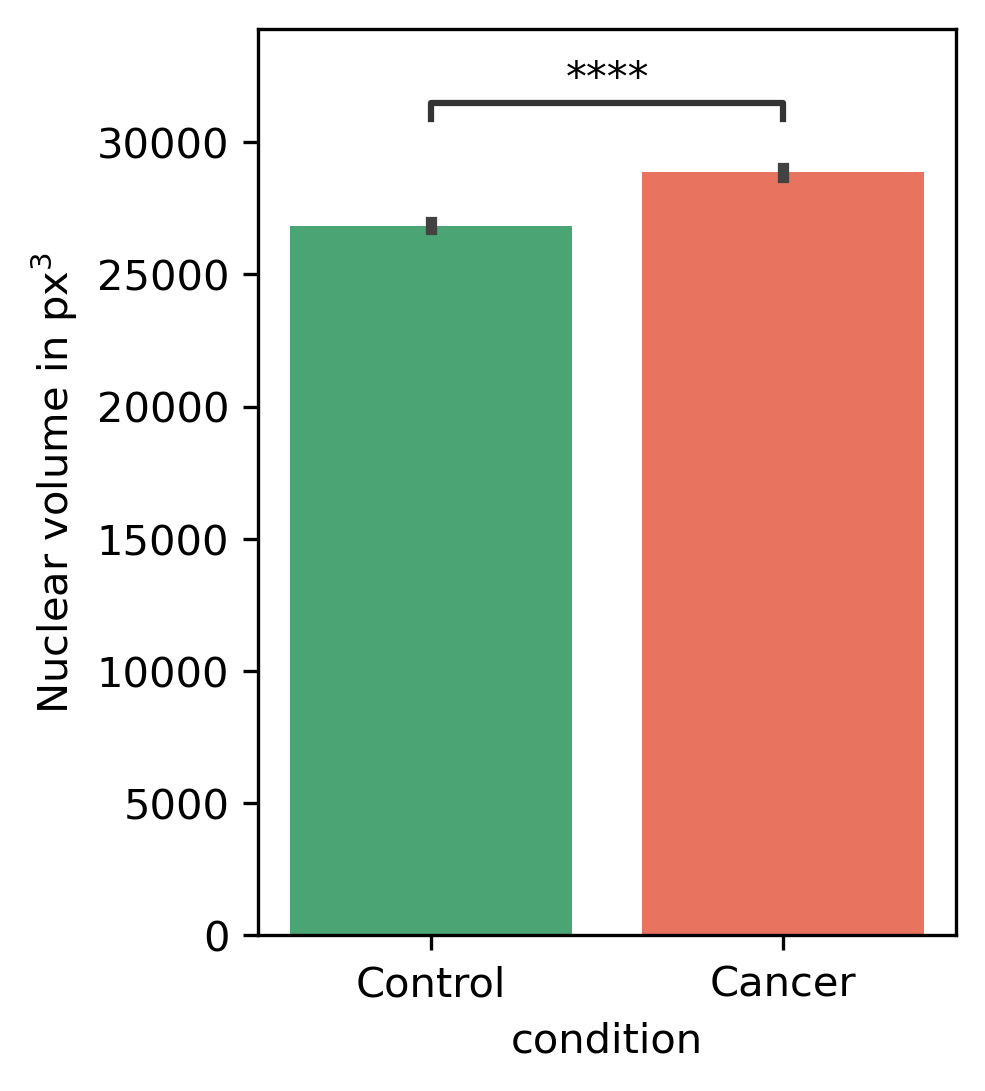

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:3.008e-186 t=-3.060e+01


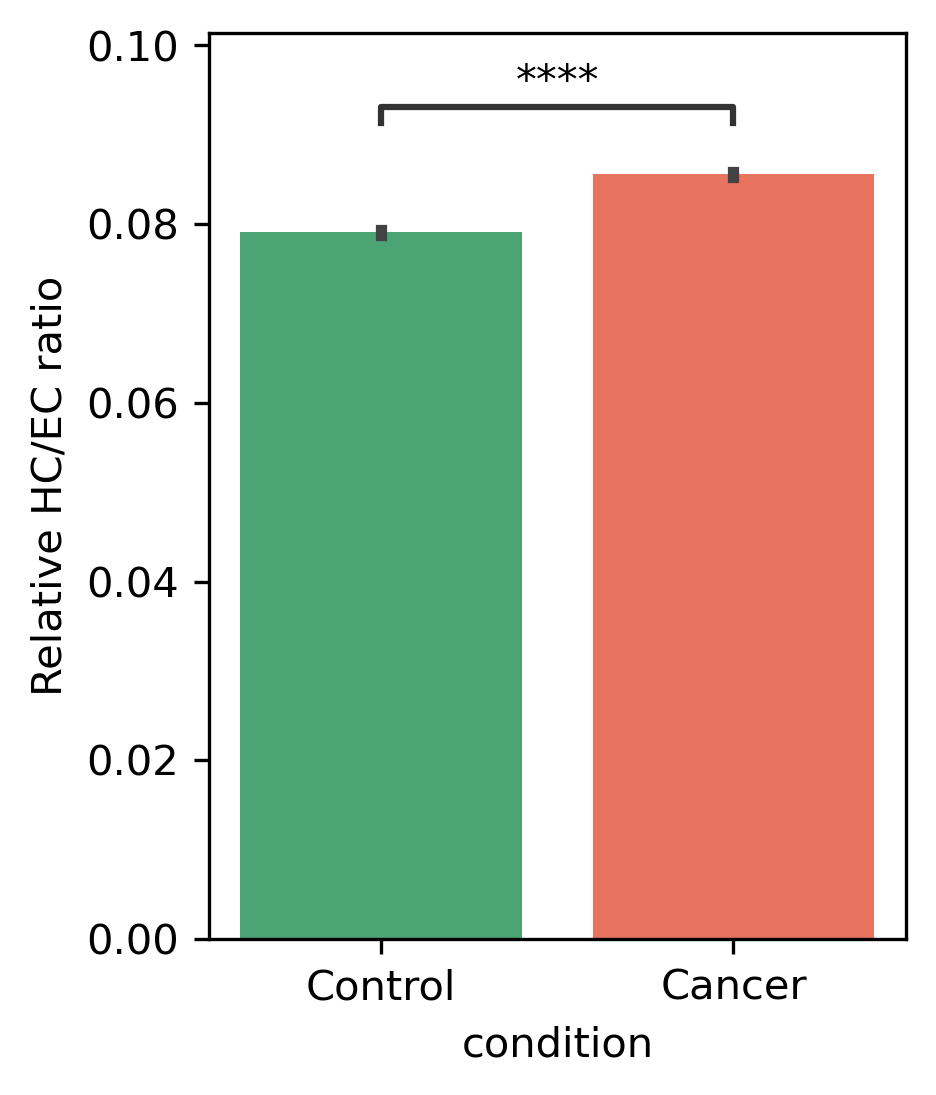

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:4.138e-263 t=-3.721e+01


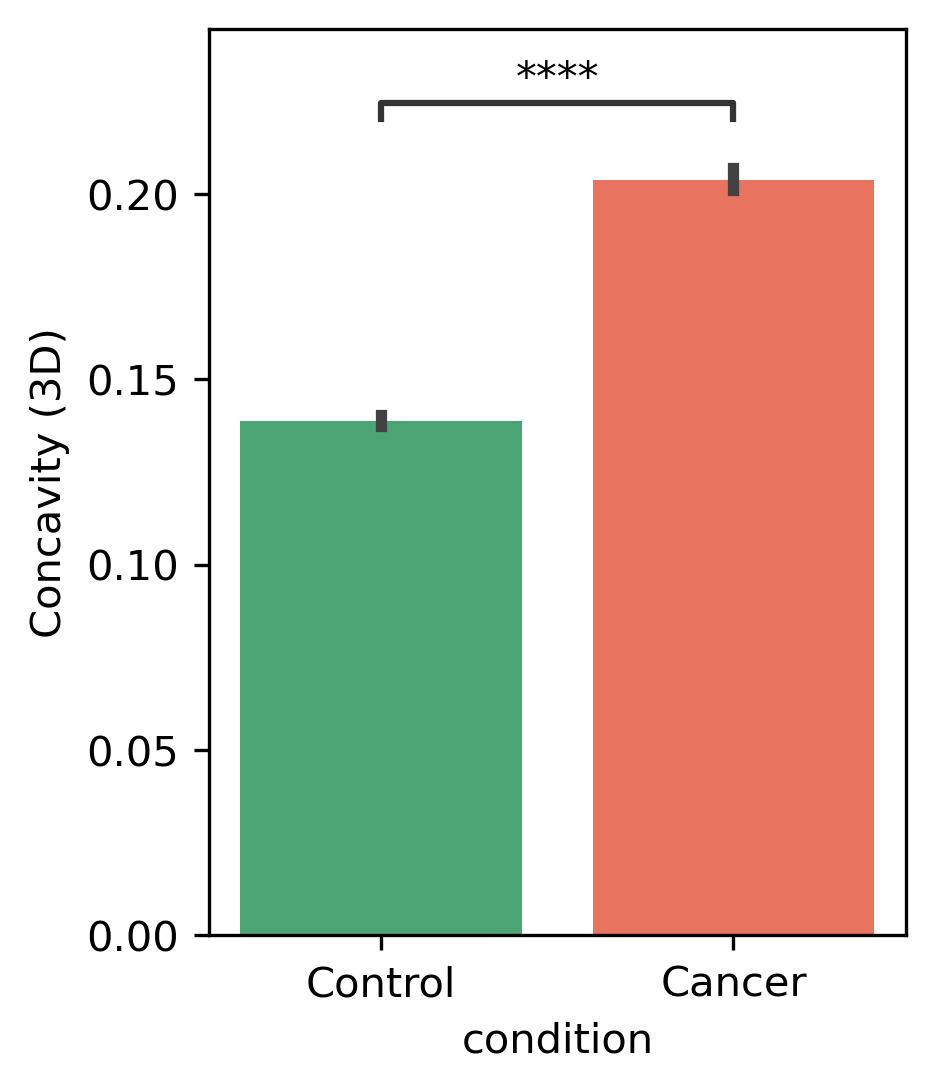

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:7.581e-65 t=1.729e+01


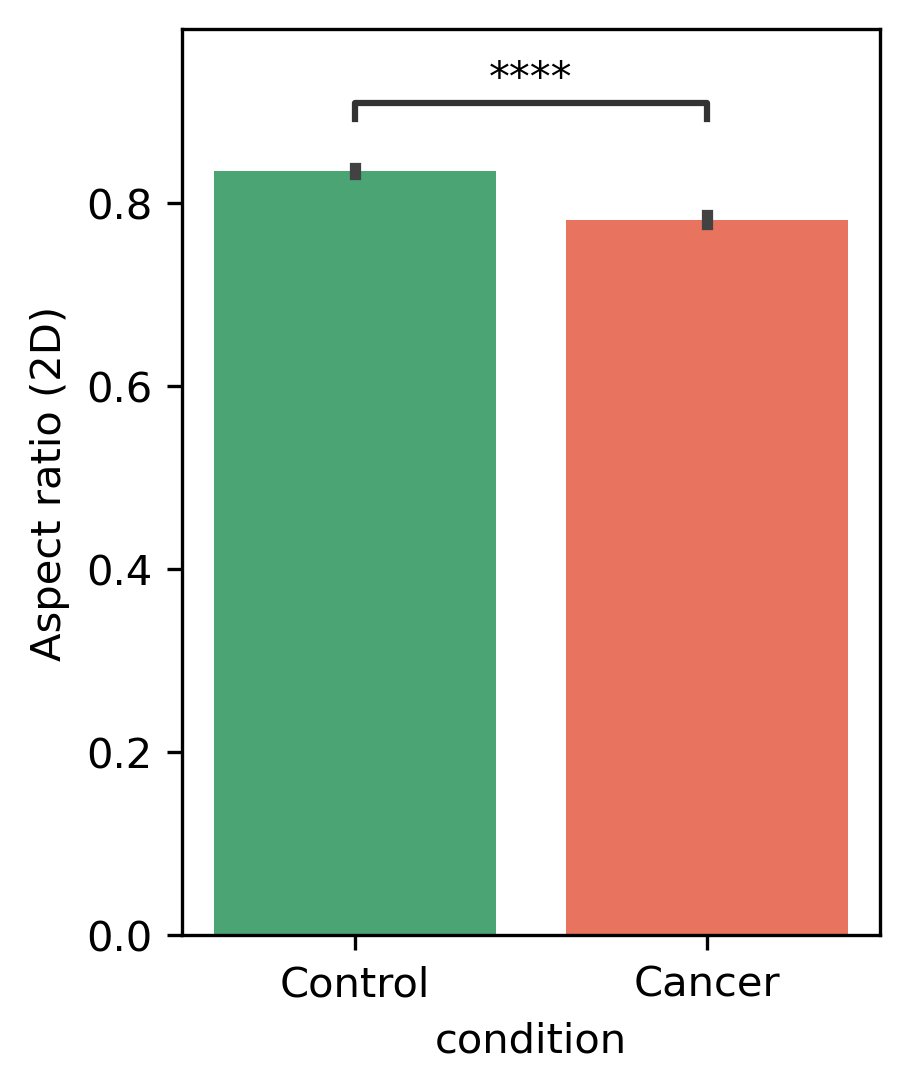

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:8.338e-124 t=-2.445e+01


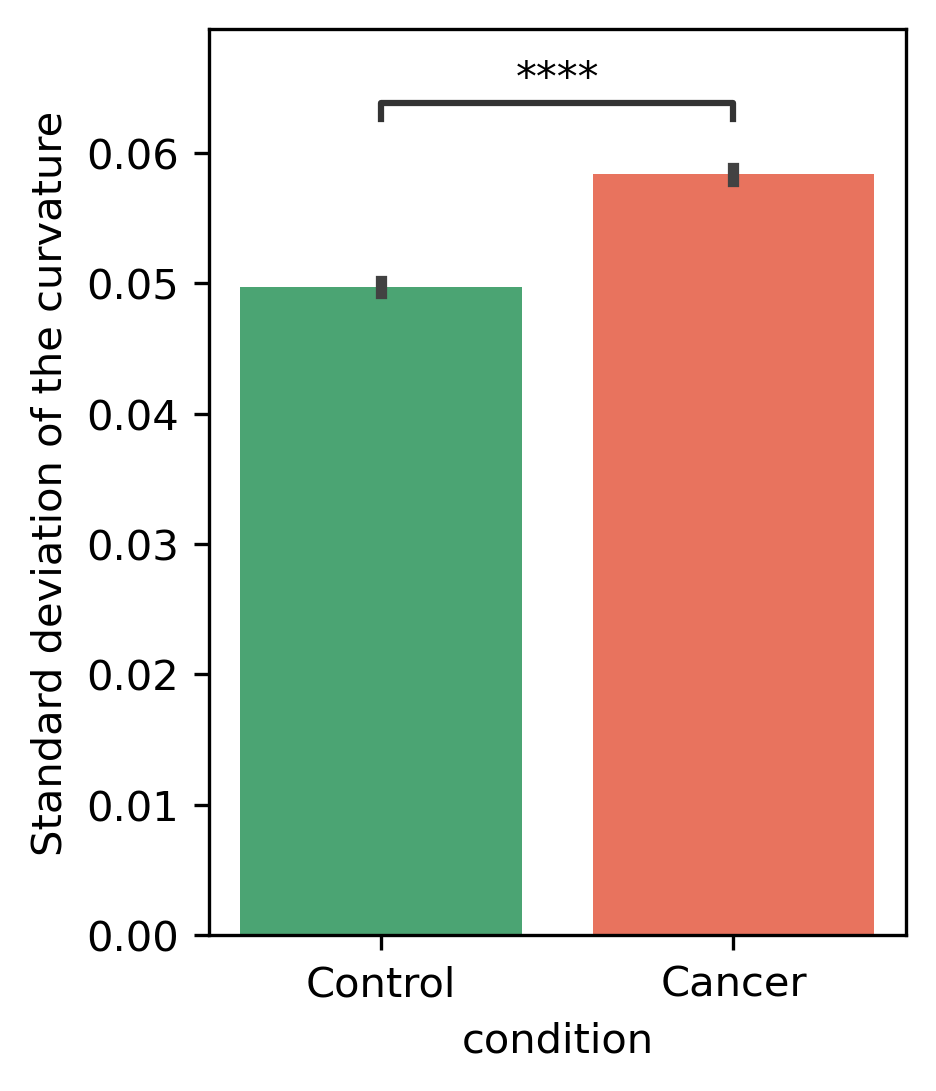

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:3.282e-243 t=3.557e+01


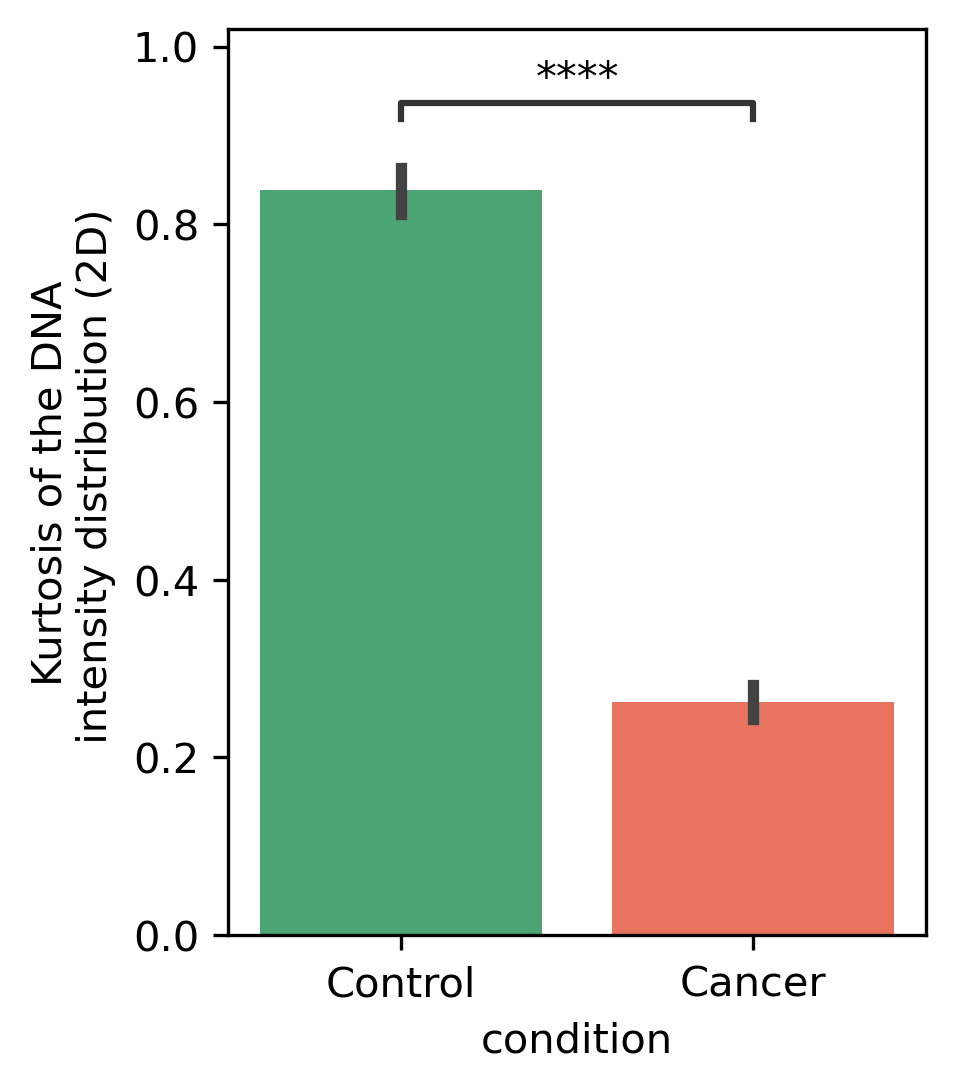

<IPython.core.display.Javascript object>

In [33]:
markers = [
    "nuclear_volume",
    "hc_ec_ratio_3d",
    "concavity_3d",
    "a_r",
    "std_curvature",
    "kurtosis",
]
marker_labels = [
    r"Nuclear volume in px$^3$",
    "Relative HC/EC ratio",
    "Concavity (3D)",
    "Aspect ratio (2D)",
    "Standard deviation of the curvature",
    "Kurtosis of the DNA\n intensity distribution (2D)",
]
plot_ctrl_cancer_markers_dist(
    data, markers, marker_labels, cut=0, palette=color_palette, plot_type="bar"
)

---

### 3d. Proteomic differences of PBMCs in cancer

Finally, we also assess the proteomic differences between the control and cancer populations. To this end, we plot the relative Lamin and gH2AX expression measured by the sum of the intensities of the corresponding imaging channels normalized by the nuclear volume. Additionally, we plot the number of identified gH2AX foci which are computed as the local maxima peaks found in the corresponding channel images.

Note that those features are only available for the first data set that was stained for those proteins.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:2.399e-47 t=1.463e+01


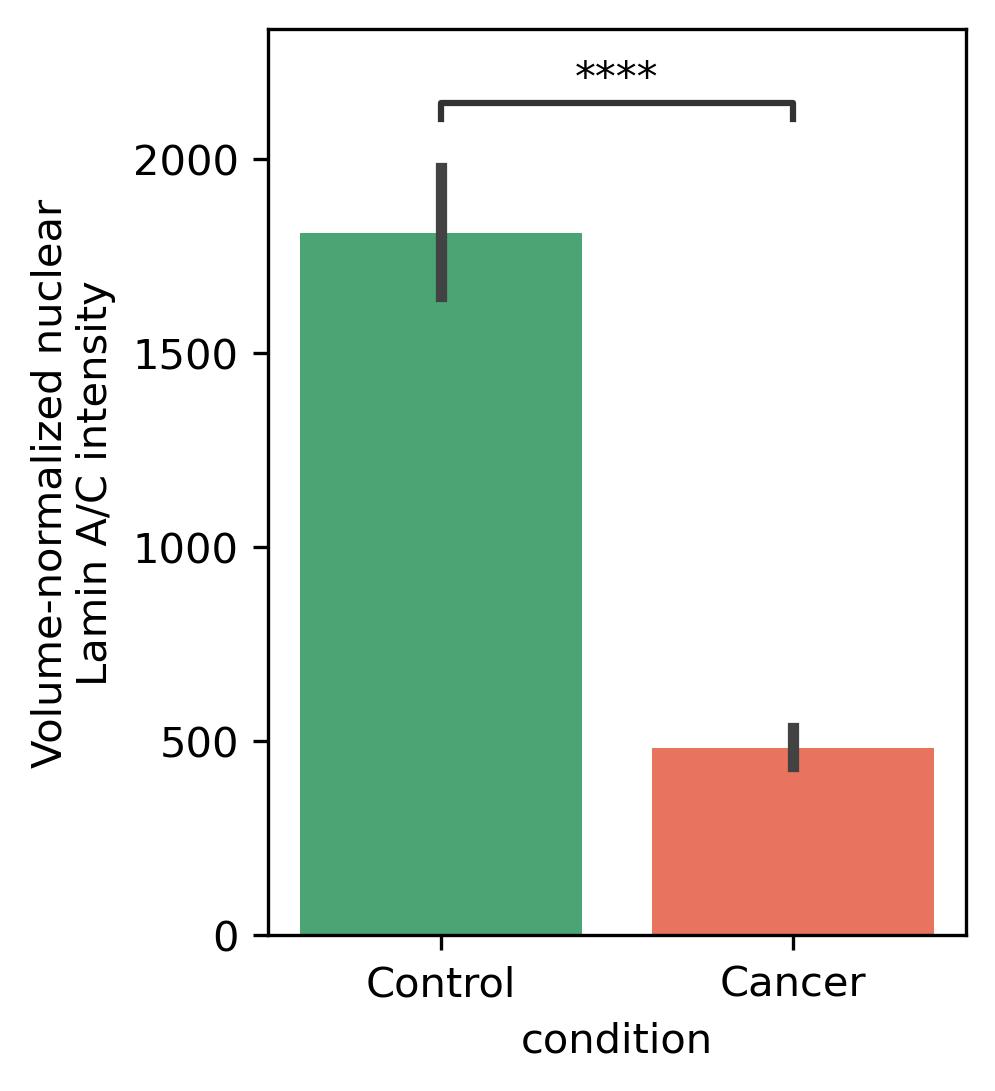

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:2.103e-148 t=2.699e+01


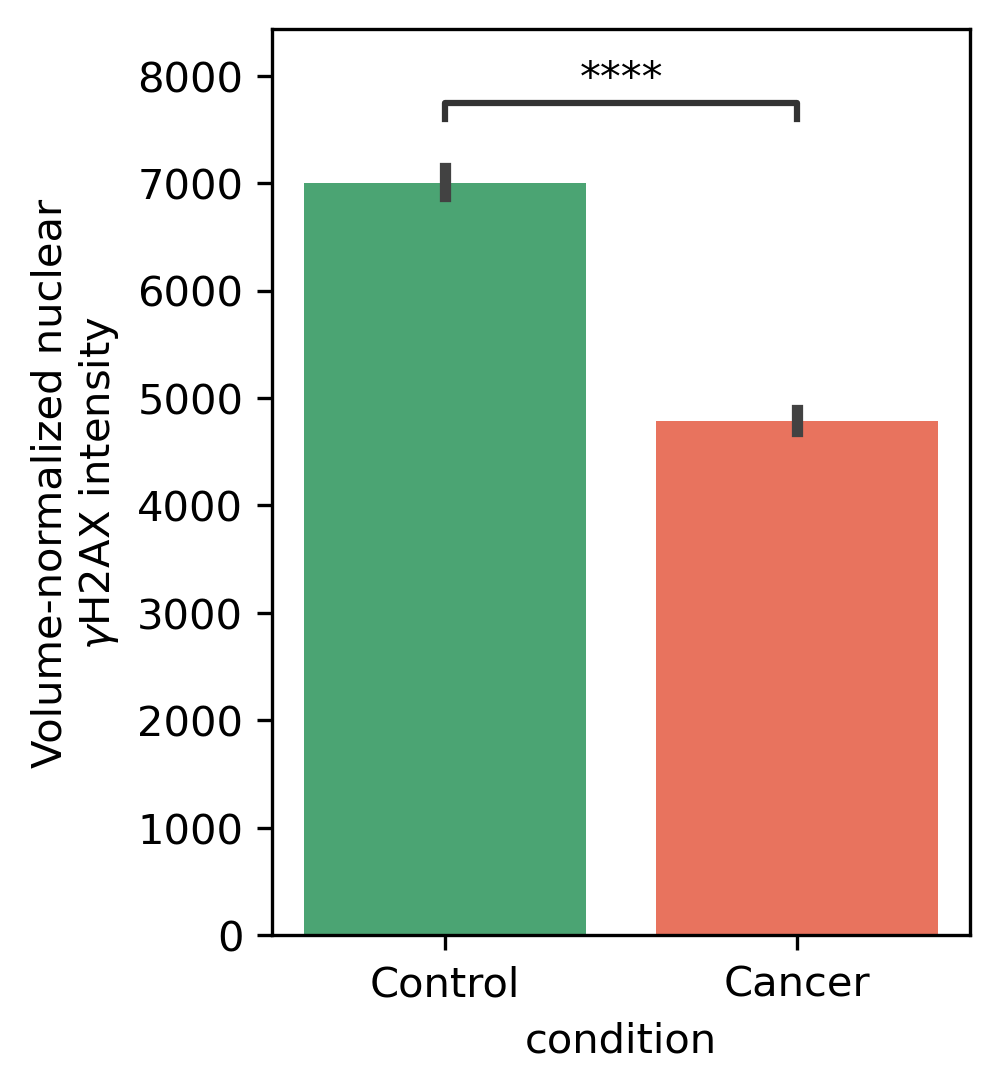

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. Cancer: t-test independent samples with Benjamini-Hochberg correction, P_val:6.823e-10 t=6.184e+00


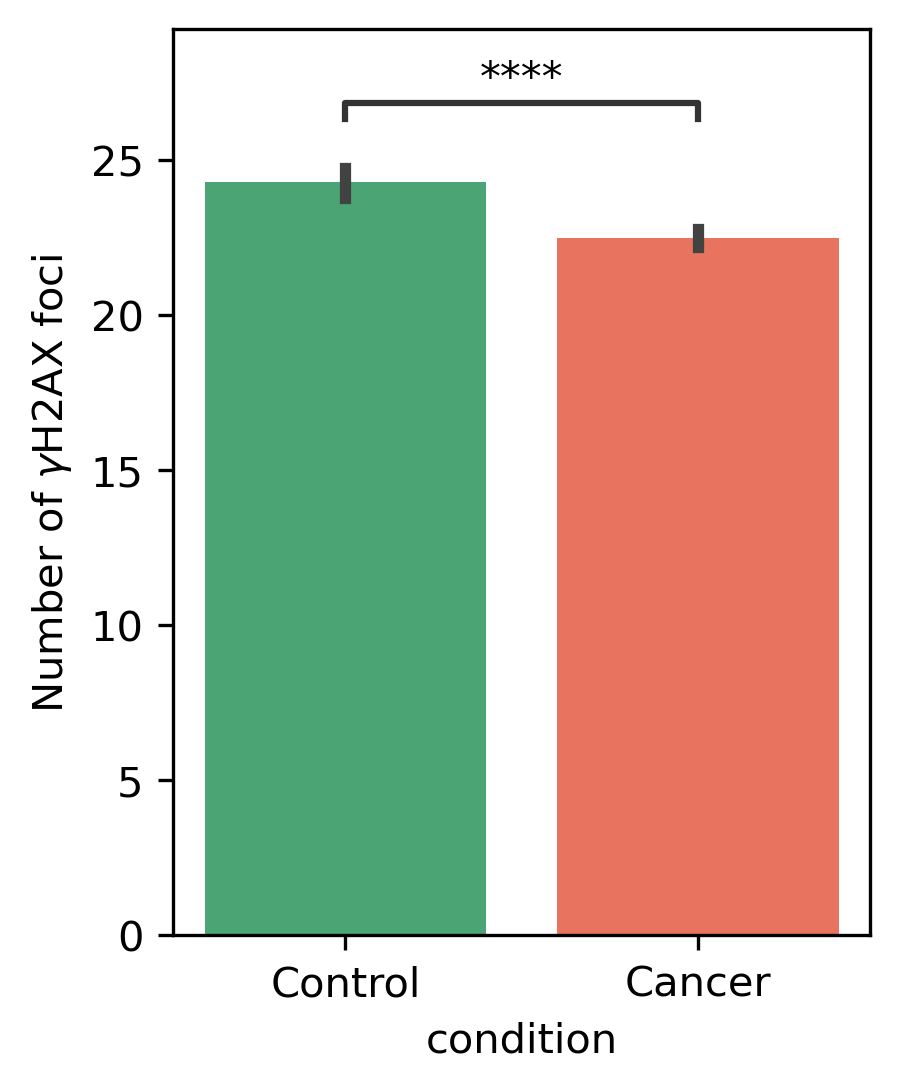

<IPython.core.display.Javascript object>

In [34]:
markers = ["rel_lamin_3d_int", "rel_gh2ax_3d_int", "gh2ax_foci_count"]
marker_labels = [
    "Volume-normalized nuclear\nLamin A/C intensity",
    "Volume-normalized nuclear\n" r"$\gamma$H2AX intensity",
    r"Number of $\gamma$H2AX foci",
]
plot_ctrl_cancer_markers_dist(
    data,
    markers,
    marker_labels,
    quantiles=None,
    cut=0,
    plot_type="bar",
    palette=color_palette,
)

---

## 4. Supplemental